# All Spectrogram Code Setup

In [1]:
%matplotlib inline
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.decomposition import NMF
from sklearn.decomposition import nmf # contains the private _beta_divergence functions that we will use
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import os

def get_all_pat_chn_trials(base_data_dir, patient_num, session_idx, tot_num_channels, 
                           core_cat, trials_type, ord):
    # TODO: Fix the default norm value to be None, and allow other norms to flow through
    """Get all trials for each channel for a given category"""    
    
    patient_ref = f"P{patient_num:02}"
    #print("patient_ref", patient_ref, sep =": ")
    patient_data_dir = os.path.join(base_data_dir, f"{patient_ref}_specgram", 
                                    f"{trials_type}", 
                                    f"session_{session_idx:02}",
                                    f"{core_cat}")
    #print("patient_data_dir", patient_data_dir, sep =": ")
    patient_csv_refs = [os.path.join(patient_data_dir, f"{patient_ref}-ses-{session_idx:02}-chn-{channel_idx + 1:02}-{core_cat}.csv") 
                        for channel_idx in tot_num_channels]
    #print("patient_csv_refs", patient_csv_refs[0], sep =": ")
    all_patient_trials = [np.loadtxt(fname = patient_csv_ref, skiprows = 1, delimiter = ",") for 
                          patient_csv_ref in patient_csv_refs]
    
    # Normalize the trial based on the specified norm type
    if ord is not None:
        print(f"we are using the {ord}-norm to normalize trials")
        all_patient_trials = [trials / np.linalg.norm(trials, ord=ord, axis=1, keepdims=True) for trials in all_patient_trials]

    return all_patient_trials

def samp_idx_without_replace(np_arr, samp_prop, sample_rows):
    """Returns a list of unique row indices from the total number of trials"""
    if sample_rows:
        # sample the number of rows
        sample_type = 0
    else:
        # sample the number of columns
        sample_type = 1
    tot_num_idxs = np_arr.shape[sample_type]
    samp_num_rows = int(np.floor(tot_num_idxs * samp_prop))
    return sorted(random.sample(range(tot_num_idxs), samp_num_rows))

def erp_gen_spectrogram(x, fs, window, nperseg, noverlap, log_Sxx):
    """Generate the spectrogram and return the modulus (or log modulus)"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    if log_Sxx:
        Sxx = np.log(Sxx)
    return f, t, Sxx

def erp_gen_welch(x, fs, window, nperseg, noverlap):
    """Estimate power spectral density using Welch’s method."""
    f, psd = signal.welch(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, psd

def specgram_trials(arr_all_trials, fs, window, nperseg, 
                    trials_samp_idx, filter_row_idx, log_Sxx):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0]) #TODO: Review this - may need to loop channel by channel if the number of channels changes!
        trial_specgrams = [erp_gen_spectrogram(x=arr_all_trials[idx], fs=fs, window=window, nperseg=nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_specgram = np.hstack(trial_specgrams)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_specgram = comb_specgram
    else:
        comb_specgram = comb_specgram[filter_row_idx]
    return comb_specgram

def specgram_wrapper(arr_all_trials, tot_num_channels, fs, window, nperseg, 
                     trials_samp_idx, filter_row_idx, log_Sxx):
    """Wrapper to produce spectrograms across all trials (or samples thereof) and the specified
       channels for the particular patient"""
    all_channels_specgrams = [specgram_trials(arr_all_trials=arr_all_trials[channel_idx],
                                              fs = fs, window = window, nperseg = nperseg,
                                              trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx,
                                              log_Sxx=log_Sxx) 
                              for channel_idx in range(len(tot_num_channels))]
    comb_all_channels_specgrams = np.hstack(all_channels_specgrams)
    return comb_all_channels_specgrams

def time_sample_specgram(comb_specgram, time_samp_idx):
    """samples a combined spectrogram of signals (horizontally stacked) and samples by time i.e. shortens by column"""
    return comb_specgram[:, time_samp_idx]    

def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

def nmf_wrapper(comb_all_channels_specgrams, n_components=5, init='random', random_state=0, 
                beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    W, H = nmf_specgrams(comb_all_channels_specgrams, n_components=n_components, init=init, random_state=random_state, 
                         beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    print("V", comb_all_channels_specgrams.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_all_channels_specgrams, W, H

### Plot the "basis" vectors i.e. columns of W

def plotW(W, log=True, x_ticks_l=None):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.style.use('seaborn')
        plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.title(f'Plot of W Component {n + 1}', fontsize=16)
        #plt.ylim(-2, W_plt.max())
        if x_ticks_l is None:
            plt.xlim(0, W_plt.shape[0])
        else:
            plt.xticks(range(0, W_plt.shape[0]), np.around(x_ticks_l), rotation='vertical')
        plt.ylabel(f'Component {n + 1}')

### Plot the rows of H i.e. the temporal activations

def plotH(H, log=False, y_ticks_l=None):
    print(H.shape[1])
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H_plt.shape[0]):
        plt.style.use('seaborn')
        plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.title(f'Plot of H Component {n + 1}', fontsize=16)
        plt.plot(H_plt[n])
        #if y_ticks_l is None:
        #    plt.ylim(0, H_plt.shape[1])
        #else:
        #    plt.yticks(range(0, H_plt.shape[1]), np.around(y_ticks_l, decimals=-1), rotation='vertical')
        #plt.ylim(0, H.max())
        plt.xlim(0, H_plt.shape[1])
        plt.ylabel(f'Component {n + 1}')
        
def entire_specgram_nmf_wrapper_cust(all_patient_trials,
                                     samp_trial_pop, 
                                     noverlap,
                                     time_samp_prop,
                                     specgram_ord,
                                     tot_num_channels,
                                     filter_row_idx,                                
                                     log_Sxx,
                                     fs, window, nperseg,
                                     n_components, 
                                     init, 
                                     random_state, 
                                     beta_loss, 
                                     solver,
                                     max_iter):
    
    """This allows you to pass in a list of matrices. Each matrix gives you the trial by millisecond view for each channel"""

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    
    print(f"The number of trials sampled is: {len(trials_samp_idx)}")

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    # Normalize the trial based on the specified norm type
    if specgram_ord is not None:
        print(f"we are using the {specgram_ord}-norm to normalize specgram")
        comb_specgram_time_sample = comb_specgram_time_sample / np.linalg.norm(x=comb_specgram_time_sample, ord=specgram_ord, axis=0, keepdims=True)
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H      

## Plot the $W$ Weighted STFTs

In [2]:
def wrapper_get_data(base_data_dir, 
                     patient_num, 
                     session_idx, 
                     tot_num_channels, 
                     core_cat, 
                     trials_type, 
                     trial_ord,
                     samp_trial_pop, 
                     noverlap,
                     time_samp_prop,
                     filter_row_idx,                                
                     log_Sxx,
                     specgram_ord,
                     fs, 
                     window, 
                     nperseg,
                     n_components,
                     init, 
                     random_state, 
                     beta_loss, 
                     solver,
                     max_iter):
    
    print(f"STARTING wrapper...")
    print(f"Getting data for P{patient_num}, Session {session_idx}, {core_cat}...")
    
    # Get all of the patient data
    print(f"Getting all_pat_chn_trials...")
    all_pat_chn_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=trial_ord)
    
    print(f"The total number of trials is: {all_pat_chn_trials[0].shape[0]}")
    
    # NMF - produce the V, W, H specnorm matrices
    print(f"Getting V_specnorm, W_specnorm, H_specnorm...")
    V_specnorm, W_specnorm, H_specnorm = entire_specgram_nmf_wrapper_cust(all_patient_trials=all_pat_chn_trials,
                                           samp_trial_pop=samp_trial_pop, 
                                           noverlap=noverlap,
                                           time_samp_prop=time_samp_prop,
                                           filter_row_idx=filter_row_idx,                                
                                           log_Sxx=log_Sxx,
                                           specgram_ord=specgram_ord,
                                           tot_num_channels=tot_num_channels,
                                           fs=fs, 
                                           window=window, 
                                           nperseg=nperseg,
                                           n_components=n_components, 
                                           init=init, 
                                           random_state=random_state, 
                                           beta_loss=beta_loss, 
                                           solver=solver,
                                           max_iter=max_iter)
    
    # Normalize W_specnorm columns for plotting
    print(f"Getting W_plt...")
    W_plt = W_specnorm / np.linalg.norm(x=W_specnorm, ord=specgram_ord, axis=0, keepdims=True)
    
    
    # Fit a single spectrogram for the parameters
    # Fit the spectrogram - no log
    print(f"Getting f, t, Sxx...")
    f, t, Sxx = erp_gen_spectrogram(x = all_pat_chn_trials[0][0], fs=fs, 
                                    window=window, nperseg=nperseg, noverlap=noverlap, 
                                    log_Sxx=log_Sxx)
    freq_ticks = f[filter_row_idx]
    
    # Fit a single STFT to a sample trial to get the relevant parameters
    print(f"Getting f_stft, t_stft, Zxx_stft...")
    f_stft, t_stft, Zxx_stft = signal.stft(x = all_pat_chn_trials[0][0], fs=fs, window=window, 
                                           nperseg=nperseg, noverlap=noverlap)
    
    print(f"FINISHED wrapper...")
    
    out_dict = {'all_pat_chn_trials': all_pat_chn_trials,
                'patient_num': patient_num, 
                'session_idx': session_idx, 
                'core_cat': core_cat,
                'V_specnorm': V_specnorm, 
                'W_specnorm': W_specnorm, 
                'H_specnorm': H_specnorm,
                'W_plt': W_plt,
                'fs': fs,
                'window': window,
                'nperseg': nperseg,
                'noverlap': noverlap,
                'f': f, 
                't': t, 
                'Sxx': Sxx,
                'freq_ticks': freq_ticks,
                'f_stft': f_stft, 
                't_stft': t_stft, 
                'Zxx_stft': Zxx_stft}
    return out_dict

In [3]:
### Produce STFT calculations

def stft_filt_normalize(Zxx_stft, filter_row_idx, mat_ord):
    #Zxx_stft_filt = np.abs(Zxx_stft[filter_row_idx, :])
    Zxx_stft_filt = np.abs(Zxx_stft[filter_row_idx, :])**2
    return Zxx_stft_filt / np.linalg.norm(x=Zxx_stft_filt, ord=mat_ord)

def get_W_comp_zeroized(f_Sxx, f_thresh, zerioze_post, W_mat, comp_idx):

    # Get the specified component
    W_comp = W_mat[:, comp_idx]

    # Normalize the W_component using 2-norm
    W_comp_scl = W_comp/np.linalg.norm(x=W_comp, ord=2, axis=0, keepdims=True)
    
    W_comp_scl2 = np.copy(W_comp_scl)

    # Based on the threshold determine the index of the frequencies we want to zeroize
    exc_thresh_argmax = np.argmax(f_Sxx > f_thresh)
    exc_thresh_argmax_po = exc_thresh_argmax + 1
    
    # Apply the zeroizing to the W scaling matrix pre/ post the
    # index based on what we are specifying
    if zerioze_post is None:
        W_comp_scl2
    elif zerioze_post:
        W_comp_scl2[exc_thresh_argmax_po:].fill(0)
    else:
        W_comp_scl2[:exc_thresh_argmax_po].fill(0)

    # Return the Z_Sxx
    return W_comp_scl2

def apply_W_comp_trial_filt(f_Sxx, f_thresh, zerioze_post, Zxx_stft_filt_scl, W_mat, comp_idx):

    W_comp_scl = get_W_comp_zeroized(f_Sxx=f_Sxx, f_thresh=f_thresh, 
                                      zerioze_post=zerioze_post, W_mat=W_mat, comp_idx=comp_idx)

    # Return the Z_Sxx
    return Zxx_stft_filt_scl.T @ W_comp_scl

### Apply W Component to STFTs

def get_all_stft(all_data_src, chnl_idx):
    
    # Extract all relevant parameters from the source
    all_pat_chn_trials = all_data_src['all_pat_chn_trials'][chnl_idx]
    num_trials = all_pat_chn_trials.shape[0]   
    fs = all_data_src['fs']
    window = all_data_src['window']
    nperseg = all_data_src['nperseg']
    noverlap = all_data_src['noverlap']    
    
    get_all_stft = [signal.stft(x = all_pat_chn_trials[tr_idx], fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
                    for tr_idx in range(num_trials)]
    return get_all_stft

def get_trial_proj(W_mat, comp_idx, get_Zxx_stft_filt_scl, f_Sxx, f_thresh, zerioze_post):
    """Apply W projection for a collection of trial STFTs
       Return the mean of all trials so that we can plot it accordingly
    """
    
    # Calculate the projection for the specified W component
    out_proj = [apply_W_comp_trial_filt(f_Sxx, f_thresh, zerioze_post, Zxx_stft_filt_scl=stft_scl, W_mat=W_mat, comp_idx=comp_idx)
                for stft_scl in get_Zxx_stft_filt_scl]
    out_proj_stack = np.vstack(out_proj)

    # Get the mean as a separate row
    mean_proj = np.mean(a=out_proj_stack, axis=0)
    
    return out_proj_stack, mean_proj

def wrapper_stft_W_proj(W_all_data_src,
                        all_faces_src,
                        all_words_src,
                        all_hammers_src,
                        chnl_num,
                        filter_row_idx,
                        mat_ord,
                        f_thresh, 
                        zerioze_post):
    
    # Get the channel index
    chnl_idx = chnl_num - 1
    
    # Get the W matrix
    W_specnorm = W_all_data_src['W_specnorm']
    
    # Get the Frobenius normalized W matrix
    # This will be used for plotting and also applying the scaling
    W_plt = W_all_data_src['W_plt']
    
    # Get the number of W components we will project onto
    n_components = W_plt.shape[1]
    
    # Get STFTs    
    get_all_stft_faces = get_all_stft(all_data_src=all_faces_src, chnl_idx=chnl_idx) # FACES - STFTs
    get_all_stft_words = get_all_stft(all_data_src=all_words_src, chnl_idx=chnl_idx) # WORDS - STFTs
    get_all_stft_hammers = get_all_stft(all_data_src=all_hammers_src, chnl_idx=chnl_idx) # HAMMERS - STFTs
    
    # Get filtered STFT, absolute valued, each entry normalized by frobenius norm of entire matrix
    get_Zxx_stft_filt_scl_faces = [stft_filt_normalize(Zxx_stft=stft[2], filter_row_idx=filter_row_idx, mat_ord=mat_ord) 
                                   for stft in get_all_stft_faces] 
    get_Zxx_stft_filt_scl_words = [stft_filt_normalize(Zxx_stft=stft[2], filter_row_idx=filter_row_idx, mat_ord=mat_ord) 
                                   for stft in get_all_stft_words] 
    get_Zxx_stft_filt_scl_hammers = [stft_filt_normalize(Zxx_stft=stft[2], filter_row_idx=filter_row_idx, mat_ord=mat_ord) 
                                   for stft in get_all_stft_hammers] 
    
    # This is used to plot the x components on W_plt
    x_ticks_l = W_all_data_src['f'][filter_row_idx]
    
    for comp_idx in range(n_components):
        
        # Set up the subplots
        fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k', squeeze=False)
        fig.subplots_adjust(hspace = 0.5, wspace=0.2)        
        axs = axs.flatten()
        
        fig.suptitle(f"W Component: {comp_idx + 1}", fontsize=14)
        
        W_comp_scl2 = get_W_comp_zeroized(f_Sxx=W_all_data_src['f'][filter_row_idx], 
                                          f_thresh=f_thresh, 
                                          zerioze_post=zerioze_post, 
                                          W_mat=W_specnorm, 
                                          comp_idx=comp_idx)
        
        # W Component
        #axs[0].plot(W_plt[:, comp_idx])
        axs[0].plot(W_comp_scl2)
        axs[0].set_ylim(0, W_comp_scl2.max())
        axs[0].set_title(f"W{comp_idx + 1}, P{W_all_data_src['patient_num']}, Session {W_all_data_src['session_idx']}, {W_all_data_src['core_cat']}", fontsize=14)
        axs[0].set_xticks(range(0, len(W_comp_scl2)))
        axs[0].set_xticklabels(np.around(x_ticks_l), rotation='vertical')
        axs[0].set_xlabel('Frequency')
        
        # Faces
        #out_convs_stack_faces, mean_convs_faces = get_trial_proj(W_mat=W_specnorm, comp_idx=comp_idx, 
        #                                                   get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_faces)
        out_convs_stack_faces, mean_convs_faces = get_trial_proj(W_mat=W_specnorm, comp_idx=comp_idx, 
                                                                 get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_faces, 
                                                                 f_Sxx=W_all_data_src['f'][filter_row_idx], f_thresh=f_thresh, 
                                                                 zerioze_post=zerioze_post)
        
        t_stft = all_faces_src['t_stft']
        axs[1].plot(out_convs_stack_faces.T[:,:])
        axs[1].plot(mean_convs_faces, marker='', color='black', linewidth=8, alpha=1.5)
        axs[1].set_title(f"P{all_faces_src['patient_num']}, Session {all_faces_src['session_idx']}, {all_faces_src['core_cat']}, Channel {chnl_idx + 1}", fontsize=14)
        axs[1].set_xticks(range(len(t_stft)))
        axs[1].set_xticklabels(np.around(t_stft*1000, 0), rotation='vertical')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel(f"W-Scaled STFT")
        
        # Words
        #out_convs_stack_words, mean_convs_words = get_trial_proj(W_mat=W_specnorm, comp_idx=comp_idx, 
        #                                                   get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_words)
        out_convs_stack_words, mean_convs_words = get_trial_proj(W_mat=W_specnorm, comp_idx=comp_idx, 
                                                                 get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_words, 
                                                                 f_Sxx=W_all_data_src['f'][filter_row_idx], f_thresh=f_thresh, 
                                                                 zerioze_post=zerioze_post)
        t_stft = all_words_src['t_stft']
        axs[2].plot(out_convs_stack_words.T[:,:])
        axs[2].plot(mean_convs_words, marker='', color='black', linewidth=8, alpha=1.5)
        axs[2].set_title(f"P{all_words_src['patient_num']}, Session {all_words_src['session_idx']}, {all_words_src['core_cat']}, Channel {chnl_idx + 1}", fontsize=14)
        axs[2].set_xticks(range(len(t_stft)))
        axs[2].set_xticklabels(np.around(t_stft*1000, 0), rotation='vertical')
        axs[2].set_xlabel('Time')
        axs[2].set_ylabel(f"W-Scaled STFT")
        
        # Hammers
        #out_convs_stack_hammers, mean_convs_hammers = get_trial_proj(W_mat=W_specnorm, comp_idx=comp_idx, 
        #                                                   get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_hammers)
        out_convs_stack_hammers, mean_convs_hammers = get_trial_proj(W_mat=W_specnorm, comp_idx=comp_idx, 
                                                                 get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_hammers, 
                                                                 f_Sxx=W_all_data_src['f'][filter_row_idx], f_thresh=f_thresh, 
                                                                 zerioze_post=zerioze_post)
        
        t_stft = all_hammers_src['t_stft']
        axs[3].plot(out_convs_stack_hammers.T[:,:])
        axs[3].plot(mean_convs_hammers, marker='', color='black', linewidth=8, alpha=1.5)
        axs[3].set_title(f"P{all_hammers_src['patient_num']}, Session {all_hammers_src['session_idx']}, {all_hammers_src['core_cat']}, Channel {chnl_idx + 1}", fontsize=14)
        axs[3].set_xticks(range(len(t_stft)))
        axs[3].set_xticklabels(np.around(t_stft*1000, 0), rotation='vertical')
        axs[3].set_xlabel('Time')
        axs[3].set_ylabel(f"W-Scaled STFT")

In [4]:
def get_half_max(arr_x, arr_y, frac):
    d = arr_y - (max(arr_y) / frac) 
    indexes = np.where(d > 0)[0] 
    fwhm = abs(arr_x[indexes[-1]] - arr_x[indexes[0]])
    peak_y_idx = np.argmax(arr_y)
    peak_y = arr_y[peak_y_idx]
    peak_x = arr_x[peak_y_idx]
    return fwhm, peak_x, peak_y

def get_half_max_W(W_mat, comp_idx, f_Sxx, f_thresh, zerioze_post, frac):
    n_components = W_mat.shape[1]
    #print(n_components)
    W_comp_scl = get_W_comp_zeroized(f_Sxx=f_Sxx, f_thresh=f_thresh, 
                                      zerioze_post=zerioze_post, W_mat=W_mat, comp_idx=comp_idx)
    #print(W_comp_scl)
    fwhm, peak_x, peak_y = get_half_max(arr_x=f_Sxx, arr_y=W_comp_scl, frac=frac)
    plt.plot(f_Sxx, W_comp_scl, 'go--', linewidth=0.5, markersize=3)
    return fwhm, peak_x

def get_half_max_allW(W_mat, f_Sxx, f_thresh, zerioze_post, frac):
    n_components = W_mat.shape[1]
    all_vals = [get_half_max(arr_x=f_Sxx, 
                             arr_y=get_W_comp_zeroized(f_Sxx=f_Sxx, f_thresh=f_thresh, zerioze_post=zerioze_post, 
                                                       W_mat=W_mat, comp_idx=comp_idx_num), frac=frac) 
                for comp_idx_num in range(n_components)]
    fwhm_vals = [all_vals[i][0] for i in range(len(all_vals))]
    peakx_vals = [all_vals[i][1] for i in range(len(all_vals))]
    peaky_vals = [all_vals[i][2] for i in range(len(all_vals))]
    
    for plt_idx in range(1):
        
        # Set up the subplots
        fig, axs = plt.subplots(1,2, figsize=(15, 6), facecolor='w', edgecolor='k', squeeze=False)
        fig.subplots_adjust(hspace = 0.5, wspace=0.2)        
        axs = axs.flatten()
        
        fig.suptitle(f"W Component: ", fontsize=14)        
        
        
        # W Component
        axs[0].scatter(peakx_vals, fwhm_vals, s=10)
        #axs[0].set_ylim(0, W_comp_scl2.max())
        axs[0].set_title(f"peak freq val vs FWHM (frac={frac})", fontsize=14)
        #axs[0].set_xticks(range(0, f_thresh))
        axs[0].set_xlabel('Frequency')

        
        axs[1].scatter(peakx_vals, peaky_vals, s=10)
        #axs[1].set_ylim(0, W_comp_scl2.max())
        axs[1].set_title(f"peak freq val vs peak W val", fontsize=14)
        #axs[1].set_xticks(range(0, f_thresh))
        axs[1].set_xlabel('Frequency')
        
    return fwhm_vals, peakx_vals, peaky_vals

def plotW_scaled(W_mat, x_ticks_l):
    
    n_components = W_mat.shape[1]
    
    fig, axs = plt.subplots(n_components, 2, figsize=(16, 20), facecolor='w', edgecolor='k', squeeze=False)
    fig.subplots_adjust(hspace = 0.9, wspace=0.2)        
    axs = axs.flatten()
    
    for n in range(n_components):
        
        # Set up the subplots
        
        #fig.suptitle(f"W Component: ", fontsize=6)    
                
        axs[2*n].plot(W_mat[:,n])
        axs[2*n].set_title(f'Plot of W Component {n + 1}', fontsize=10)
        #axs[2*n].set_xticks(range(0, W_mat.shape[0]))
        axs[2*n].set_xticklabels(np.around(x_ticks_l), rotation='vertical')
        #axs[n].set_xlabel(f'Component {n + 1}')
        
        W_comp_scl = W_mat[:,n]/np.linalg.norm(x=W_mat[:,n], ord=2, axis=0, keepdims=True)
        axs[2*n+1].plot(W_comp_scl)
        axs[2*n+1].set_title(f'Plot of W Component {n + 1} - Normalized', fontsize=10)
        #axs[2*n+1].set_xticks(range(0, W_mat.shape[0]))
        axs[2*n+1].set_xticklabels(np.around(x_ticks_l), rotation='vertical')

# Run Wrapper

# COMMON PARAMETERS for the DATA GENERATION

In [5]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
trials_type = "category"
session_idx = 1
trial_ord = None

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 156
log_Sxx=False

samp_trial_pop = 0.8 # 100% sampling of trials
time_samp_prop = 1.0 # 100% sampling of time
specgram_ord = 2 # Normalize spectrogram using Frobenius Norm
filter_row_idx=range(39) # Sample at 200Hz
n_components_low = 8 
n_components_high = n_components_low * 2 # Double the number of components
init = 'random' 
random_state = 0
beta_loss = 'itakura-saito' # IS Divergence
solver = 'mu'
max_iter = 400

## P41 and P35 data creation - Individual Category NMF - P41 and P35

In [6]:
# P41 Faces
P41_faces_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                  patient_num=41, 
                                  session_idx=session_idx, 
                                  tot_num_channels=range(96), 
                                  core_cat="Faces", 
                                  trials_type=trials_type, 
                                  trial_ord=trial_ord,
                                  samp_trial_pop=samp_trial_pop, 
                                  noverlap=noverlap,
                                  time_samp_prop=time_samp_prop,
                                  filter_row_idx=filter_row_idx,                                
                                  log_Sxx=log_Sxx,
                                  specgram_ord=specgram_ord,
                                  fs=fs, 
                                  window=window, 
                                  nperseg=nperseg,
                                  n_components=n_components_low,
                                  init=init, 
                                  random_state=random_state, 
                                  beta_loss=beta_loss, 
                                  solver=solver,
                                  max_iter=max_iter)

# P41 Words
P41_words_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                  patient_num=41, 
                                  session_idx=session_idx, 
                                  tot_num_channels=range(96), 
                                  core_cat="Words", 
                                  trials_type=trials_type, 
                                  trial_ord=trial_ord,
                                  samp_trial_pop=samp_trial_pop, 
                                  noverlap=noverlap,
                                  time_samp_prop=time_samp_prop,
                                  filter_row_idx=filter_row_idx,                                
                                  log_Sxx=log_Sxx,
                                  specgram_ord=specgram_ord,
                                  fs=fs, 
                                  window=window, 
                                  nperseg=nperseg,
                                  n_components=n_components_low,
                                  init=init, 
                                  random_state=random_state, 
                                  beta_loss=beta_loss, 
                                  solver=solver,
                                  max_iter=max_iter)

# P41 Hammers
P41_hammers_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                  patient_num=41, 
                                  session_idx=session_idx, 
                                  tot_num_channels=range(96), 
                                  core_cat="Hammers", 
                                  trials_type=trials_type, 
                                  trial_ord=trial_ord,
                                  samp_trial_pop=samp_trial_pop, 
                                  noverlap=noverlap,
                                  time_samp_prop=time_samp_prop,
                                  filter_row_idx=filter_row_idx,                                
                                  log_Sxx=log_Sxx,
                                  specgram_ord=specgram_ord,
                                  fs=fs, 
                                  window=window, 
                                  nperseg=nperseg,
                                  n_components=n_components_low,
                                  init=init, 
                                  random_state=random_state, 
                                  beta_loss=beta_loss, 
                                  solver=solver,
                                  max_iter=max_iter)

# P35 Faces
P35_faces_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                  patient_num=35, 
                                  session_idx=session_idx, 
                                  tot_num_channels=range(85), 
                                  core_cat="Faces", 
                                  trials_type=trials_type, 
                                  trial_ord=trial_ord,
                                  samp_trial_pop=samp_trial_pop, 
                                  noverlap=noverlap,
                                  time_samp_prop=time_samp_prop,
                                  filter_row_idx=filter_row_idx,                                
                                  log_Sxx=log_Sxx,
                                  specgram_ord=specgram_ord,
                                  fs=fs, 
                                  window=window, 
                                  nperseg=nperseg,
                                  n_components=n_components_low,
                                  init=init, 
                                  random_state=random_state, 
                                  beta_loss=beta_loss, 
                                  solver=solver,
                                  max_iter=max_iter)

# P35 Words
P35_words_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                  patient_num=35, 
                                  session_idx=session_idx, 
                                  tot_num_channels=range(85), 
                                  core_cat="Words", 
                                  trials_type=trials_type, 
                                  trial_ord=trial_ord,
                                  samp_trial_pop=samp_trial_pop, 
                                  noverlap=noverlap,
                                  time_samp_prop=time_samp_prop,
                                  filter_row_idx=filter_row_idx,                                
                                  log_Sxx=log_Sxx,
                                  specgram_ord=specgram_ord,
                                  fs=fs, 
                                  window=window, 
                                  nperseg=nperseg,
                                  n_components=n_components_low,
                                  init=init, 
                                  random_state=random_state, 
                                  beta_loss=beta_loss, 
                                  solver=solver,
                                  max_iter=max_iter)

# P35 Hammers
P35_hammers_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                  patient_num=35, 
                                  session_idx=session_idx, 
                                  tot_num_channels=range(85), 
                                  core_cat="Hammers", 
                                  trials_type=trials_type, 
                                  trial_ord=trial_ord,
                                  samp_trial_pop=samp_trial_pop, 
                                  noverlap=noverlap,
                                  time_samp_prop=time_samp_prop,
                                  filter_row_idx=filter_row_idx,                                
                                  log_Sxx=log_Sxx,
                                  specgram_ord=specgram_ord,
                                  fs=fs, 
                                  window=window, 
                                  nperseg=nperseg,
                                  n_components=n_components_low,
                                  init=init, 
                                  random_state=random_state, 
                                  beta_loss=beta_loss, 
                                  solver=solver,
                                  max_iter=max_iter)

STARTING wrapper...
Getting data for P41, Session 1, Faces...
Getting all_pat_chn_trials...
The total number of trials is: 84
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 67
comb_all_channels_specgrams: (39, 237984)
time_samp_idx length: 237984
comb_specgram_time_sample: (39, 237984)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (39, 237984)
W: (39, 8)
H: (8, 237984)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...
STARTING wrapper...
Getting data for P41, Session 1, Words...
Getting all_pat_chn_trials...
The total number of trials is: 81
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 64
comb_all_channels_specgrams: (39, 227328)
time_samp_idx length: 227328
comb_specgram_time_sample: (39, 227328)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (39, 227328)
W: (39, 8)
H: (8, 227328)
NMF COMPLETE!
Getting W_plt...
Getting f, t, S

## P35 Session 2

In [47]:
# P35 Faces
P35_faces_data_session2 = wrapper_get_data(base_data_dir=base_data_dir, 
                                  patient_num=35, 
                                  session_idx=2, # Session 2 
                                  tot_num_channels=range(85), 
                                  core_cat="Faces", 
                                  trials_type=trials_type, 
                                  trial_ord=trial_ord,
                                  samp_trial_pop=samp_trial_pop, 
                                  noverlap=noverlap,
                                  time_samp_prop=time_samp_prop,
                                  filter_row_idx=filter_row_idx,                                
                                  log_Sxx=log_Sxx,
                                  specgram_ord=specgram_ord,
                                  fs=fs, 
                                  window=window, 
                                  nperseg=nperseg,
                                  n_components=n_components_low,
                                  init=init, 
                                  random_state=random_state, 
                                  beta_loss=beta_loss, 
                                  solver=solver,
                                  max_iter=max_iter)

# P35 Words
P35_words_data_session2 = wrapper_get_data(base_data_dir=base_data_dir, 
                                  patient_num=35, 
                                  session_idx=2, # Session 2 
                                  tot_num_channels=range(85), 
                                  core_cat="Words", 
                                  trials_type=trials_type, 
                                  trial_ord=trial_ord,
                                  samp_trial_pop=samp_trial_pop, 
                                  noverlap=noverlap,
                                  time_samp_prop=time_samp_prop,
                                  filter_row_idx=filter_row_idx,                                
                                  log_Sxx=log_Sxx,
                                  specgram_ord=specgram_ord,
                                  fs=fs, 
                                  window=window, 
                                  nperseg=nperseg,
                                  n_components=n_components_low,
                                  init=init, 
                                  random_state=random_state, 
                                  beta_loss=beta_loss, 
                                  solver=solver,
                                  max_iter=max_iter)

# P35 Hammers
P35_hammers_data_session2 = wrapper_get_data(base_data_dir=base_data_dir, 
                                  patient_num=35, 
                                  session_idx=2, # Session 2 
                                  tot_num_channels=range(85), 
                                  core_cat="Hammers", 
                                  trials_type=trials_type, 
                                  trial_ord=trial_ord,
                                  samp_trial_pop=samp_trial_pop, 
                                  noverlap=noverlap,
                                  time_samp_prop=time_samp_prop,
                                  filter_row_idx=filter_row_idx,                                
                                  log_Sxx=log_Sxx,
                                  specgram_ord=specgram_ord,
                                  fs=fs, 
                                  window=window, 
                                  nperseg=nperseg,
                                  n_components=n_components_low,
                                  init=init, 
                                  random_state=random_state, 
                                  beta_loss=beta_loss, 
                                  solver=solver,
                                  max_iter=max_iter)

STARTING wrapper...
Getting data for P35, Session 2, Faces...
Getting all_pat_chn_trials...
The total number of trials is: 82
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 65
comb_all_channels_specgrams: (39, 204425)
time_samp_idx length: 204425
comb_specgram_time_sample: (39, 204425)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (39, 204425)
W: (39, 8)
H: (8, 204425)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...
STARTING wrapper...
Getting data for P35, Session 2, Words...
Getting all_pat_chn_trials...
The total number of trials is: 82
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 65
comb_all_channels_specgrams: (39, 204425)
time_samp_idx length: 204425
comb_specgram_time_sample: (39, 204425)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (39, 204425)
W: (39, 8)
H: (8, 204425)
NMF COMPLETE!
Getting W_plt...
Getting f, t, S

## P35 data creation - All Category NMF P35

- P35 All - 16% trials, 8 components
- P35 All - 32% trials, 8 components
- P35 All - 16% trials, 16 components
- P35 All - 32% trials, 16 components

In [7]:
# P35 All - 16% trials, 8 components
P35_allcats_16ptrl_ncomp_low_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                                     patient_num=35, 
                                                     session_idx=session_idx, 
                                                     tot_num_channels=range(85), 
                                                     core_cat="Allcats", 
                                                     trials_type=trials_type, 
                                                     trial_ord=trial_ord,
                                                     samp_trial_pop=0.16, 
                                                     noverlap=noverlap,
                                                     time_samp_prop=time_samp_prop,
                                                     filter_row_idx=filter_row_idx,                                
                                                     log_Sxx=log_Sxx,
                                                     specgram_ord=specgram_ord,
                                                     fs=fs, 
                                                     window=window, 
                                                     nperseg=nperseg,
                                                     n_components=n_components_low, # Lower number of components
                                                     init=init, 
                                                     random_state=random_state, 
                                                     beta_loss=beta_loss, 
                                                     solver=solver,
                                                     max_iter=max_iter)

STARTING wrapper...
Getting data for P35, Session 1, Allcats...
Getting all_pat_chn_trials...
The total number of trials is: 480
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 76
comb_all_channels_specgrams: (39, 239020)
time_samp_idx length: 239020
comb_specgram_time_sample: (39, 239020)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (39, 239020)
W: (39, 8)
H: (8, 239020)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...


In [8]:
# P35 All - 32% trials, 8 components
P35_allcats_32ptrl_ncomp_low_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                                     patient_num=35, 
                                                     session_idx=session_idx, 
                                                     tot_num_channels=range(85), 
                                                     core_cat="Allcats", 
                                                     trials_type=trials_type, 
                                                     trial_ord=trial_ord,
                                                     samp_trial_pop=0.32, # Increase proportion of trials to 32% 
                                                     noverlap=noverlap,
                                                     time_samp_prop=time_samp_prop,
                                                     filter_row_idx=filter_row_idx,                                
                                                     log_Sxx=log_Sxx,
                                                     specgram_ord=specgram_ord,
                                                     fs=fs, 
                                                     window=window, 
                                                     nperseg=nperseg,
                                                     n_components=n_components_low, # Lower number of components
                                                     init=init, 
                                                     random_state=random_state, 
                                                     beta_loss=beta_loss, 
                                                     solver=solver,
                                                     max_iter=max_iter)

STARTING wrapper...
Getting data for P35, Session 1, Allcats...
Getting all_pat_chn_trials...
The total number of trials is: 480
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 153
comb_all_channels_specgrams: (39, 481185)
time_samp_idx length: 481185
comb_specgram_time_sample: (39, 481185)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (39, 481185)
W: (39, 8)
H: (8, 481185)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...


In [9]:
# P35 All - 16% trials, 16 components
P35_allcats_16ptrl_ncomp_high_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                                     patient_num=35, 
                                                     session_idx=session_idx, 
                                                     tot_num_channels=range(85), 
                                                     core_cat="Allcats", 
                                                     trials_type=trials_type, 
                                                     trial_ord=trial_ord,
                                                     samp_trial_pop=0.16, 
                                                     noverlap=noverlap,
                                                     time_samp_prop=time_samp_prop,
                                                     filter_row_idx=filter_row_idx,                                
                                                     log_Sxx=log_Sxx,
                                                     specgram_ord=specgram_ord,
                                                     fs=fs, 
                                                     window=window, 
                                                     nperseg=nperseg,
                                                     n_components=n_components_high, # Lower number of components
                                                     init=init, 
                                                     random_state=random_state, 
                                                     beta_loss=beta_loss, 
                                                     solver=solver,
                                                     max_iter=max_iter)

STARTING wrapper...
Getting data for P35, Session 1, Allcats...
Getting all_pat_chn_trials...
The total number of trials is: 480
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 76
comb_all_channels_specgrams: (39, 239020)
time_samp_idx length: 239020
comb_specgram_time_sample: (39, 239020)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (39, 239020)
W: (39, 16)
H: (16, 239020)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...


In [10]:
# P35 All - 32% trials, 16 components
P35_allcats_32ptrl_ncomp_high_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                                     patient_num=35, 
                                                     session_idx=session_idx, 
                                                     tot_num_channels=range(85), 
                                                     core_cat="Allcats", 
                                                     trials_type=trials_type, 
                                                     trial_ord=trial_ord,
                                                     samp_trial_pop=0.32, # Increase proportion of trials to 32% 
                                                     noverlap=noverlap,
                                                     time_samp_prop=time_samp_prop,
                                                     filter_row_idx=filter_row_idx,                                
                                                     log_Sxx=log_Sxx,
                                                     specgram_ord=specgram_ord,
                                                     fs=fs, 
                                                     window=window, 
                                                     nperseg=nperseg,
                                                     n_components=n_components_high, # Higher number of components
                                                     init=init, 
                                                     random_state=random_state, 
                                                     beta_loss=beta_loss, 
                                                     solver=solver,
                                                     max_iter=max_iter)

STARTING wrapper...
Getting data for P35, Session 1, Allcats...
Getting all_pat_chn_trials...
The total number of trials is: 480
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 153
comb_all_channels_specgrams: (39, 481185)
time_samp_idx length: 481185
comb_specgram_time_sample: (39, 481185)
we are using the 2-norm to normalize specgram
STARTING NMF...


/Users/shamindras/anaconda/envs/sklearnprod1/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


V: (39, 481185)
W: (39, 16)
H: (16, 481185)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...


## P41 data creation - All Category NMF P35

- P41 All - 16% trials, 8 components
- P41 All - 32% trials, 8 components
- P41 All - 16% trials, 16 components
- P41 All - 32% trials, 16 components

In [11]:
# P41 All - 16% trials, 8 components
P41_allcats_16ptrl_ncomp_low_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                                     patient_num=41, 
                                                     session_idx=session_idx, 
                                                     tot_num_channels=range(96), 
                                                     core_cat="Allcats", 
                                                     trials_type=trials_type, 
                                                     trial_ord=trial_ord,
                                                     samp_trial_pop=0.16, 
                                                     noverlap=noverlap,
                                                     time_samp_prop=time_samp_prop,
                                                     filter_row_idx=filter_row_idx,                                
                                                     log_Sxx=log_Sxx,
                                                     specgram_ord=specgram_ord,
                                                     fs=fs, 
                                                     window=window, 
                                                     nperseg=nperseg,
                                                     n_components=n_components_low,
                                                     init=init, 
                                                     random_state=random_state, 
                                                     beta_loss=beta_loss, 
                                                     solver=solver,
                                                     max_iter=max_iter)

STARTING wrapper...
Getting data for P41, Session 1, Allcats...
Getting all_pat_chn_trials...
The total number of trials is: 480
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 76
comb_all_channels_specgrams: (39, 269952)
time_samp_idx length: 269952
comb_specgram_time_sample: (39, 269952)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (39, 269952)
W: (39, 8)
H: (8, 269952)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...


In [12]:
# P41 All - 32% trials, 8 components
P41_allcats_32ptrl_ncomp_low_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                                     patient_num=41, 
                                                     session_idx=session_idx, 
                                                     tot_num_channels=range(96), 
                                                     core_cat="Allcats", 
                                                     trials_type=trials_type, 
                                                     trial_ord=trial_ord,
                                                     samp_trial_pop=0.32, # Increase proportion of trials to 32%
                                                     noverlap=noverlap,
                                                     time_samp_prop=time_samp_prop,
                                                     filter_row_idx=filter_row_idx,                                
                                                     log_Sxx=log_Sxx,
                                                     specgram_ord=specgram_ord,
                                                     fs=fs, 
                                                     window=window, 
                                                     nperseg=nperseg,
                                                     n_components=n_components_low,
                                                     init=init, 
                                                     random_state=random_state, 
                                                     beta_loss=beta_loss, 
                                                     solver=solver,
                                                     max_iter=max_iter)

STARTING wrapper...
Getting data for P41, Session 1, Allcats...
Getting all_pat_chn_trials...
The total number of trials is: 480
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 153
comb_all_channels_specgrams: (39, 543456)
time_samp_idx length: 543456
comb_specgram_time_sample: (39, 543456)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (39, 543456)
W: (39, 8)
H: (8, 543456)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...


In [13]:
# P41 All - 16% trials, 16 components
P41_allcats_16ptrl_ncomp_high_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                                     patient_num=41, 
                                                     session_idx=session_idx, 
                                                     tot_num_channels=range(96), 
                                                     core_cat="Allcats", 
                                                     trials_type=trials_type, 
                                                     trial_ord=trial_ord,
                                                     samp_trial_pop=0.16, 
                                                     noverlap=noverlap,
                                                     time_samp_prop=time_samp_prop,
                                                     filter_row_idx=filter_row_idx,                                
                                                     log_Sxx=log_Sxx,
                                                     specgram_ord=specgram_ord,
                                                     fs=fs, 
                                                     window=window, 
                                                     nperseg=nperseg,
                                                     n_components=n_components_high,
                                                     init=init, 
                                                     random_state=random_state, 
                                                     beta_loss=beta_loss, 
                                                     solver=solver,
                                                     max_iter=max_iter)

STARTING wrapper...
Getting data for P41, Session 1, Allcats...
Getting all_pat_chn_trials...
The total number of trials is: 480
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 76
comb_all_channels_specgrams: (39, 269952)
time_samp_idx length: 269952
comb_specgram_time_sample: (39, 269952)
we are using the 2-norm to normalize specgram
STARTING NMF...


/Users/shamindras/anaconda/envs/sklearnprod1/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


V: (39, 269952)
W: (39, 16)
H: (16, 269952)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...


In [14]:
# P41 All - 32% trials, 16 components
P41_allcats_32ptrl_ncomp_high_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                                     patient_num=41, 
                                                     session_idx=session_idx, 
                                                     tot_num_channels=range(96), 
                                                     core_cat="Allcats", 
                                                     trials_type=trials_type, 
                                                     trial_ord=trial_ord,
                                                     samp_trial_pop=0.32, # Increase proportion of trials to 32%
                                                     noverlap=noverlap,
                                                     time_samp_prop=time_samp_prop,
                                                     filter_row_idx=filter_row_idx,                                
                                                     log_Sxx=log_Sxx,
                                                     specgram_ord=specgram_ord,
                                                     fs=fs, 
                                                     window=window, 
                                                     nperseg=nperseg,
                                                     n_components=n_components_high,
                                                     init=init, 
                                                     random_state=random_state, 
                                                     beta_loss=beta_loss, 
                                                     solver=solver,
                                                     max_iter=max_iter)

STARTING wrapper...
Getting data for P41, Session 1, Allcats...
Getting all_pat_chn_trials...
The total number of trials is: 480
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 153
comb_all_channels_specgrams: (39, 543456)
time_samp_idx length: 543456
comb_specgram_time_sample: (39, 543456)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (39, 543456)
W: (39, 16)
H: (16, 543456)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...


## P41 - Session 1, $W$ All Categories - Channel 9 (Word sensitive channel) vs P41

- P41 All - 32% trials, 16 components

In [ ]:
chnl_num=9
wrapper_stft_W_proj(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                    all_faces_src=P41_faces_data,
                    all_words_src=P41_words_data,
                    all_hammers_src=P41_hammers_data,
                    chnl_num=chnl_num,
                    filter_row_idx=range(39),
                    mat_ord='fro',
                    f_thresh=60, 
                    zerioze_post=None)

In [ ]:
chnl_num=1
wrapper_stft_W_proj(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                    all_faces_src=P35_faces_data_session2,
                    all_words_src=P35_words_data_session2,
                    all_hammers_src=P35_hammers_data_session2,
                    chnl_num=chnl_num,
                    filter_row_idx=range(39),
                    mat_ord='fro',
                    f_thresh=60, 
                    zerioze_post=None)

## Get all $W$ projected data

In [19]:
def get_wrapper_stft_W_proj_data(W_all_data_src,
                                 speccat_src,
                                 chnl_num,
                                 filter_row_idx,
                                 mat_ord,
                                 f_thresh, 
                                 zerioze_post):
    
    # Get the channel index
    chnl_idx = chnl_num - 1
    
    # Get the W matrix
    W_specnorm = W_all_data_src['W_specnorm']
    
    # Get the Frobenius normalized W matrix
    # This will be used for plotting and also applying the scaling
    W_plt = W_all_data_src['W_plt']
    
    # Get the number of W components we will project onto
    n_components = W_plt.shape[1]
    
    # Get STFTs    
    get_all_stft_speccat = get_all_stft(all_data_src=speccat_src, chnl_idx=chnl_idx) # Specified Categories - STFTs
    
    # Get filtered STFT, absolute valued, each entry normalized by frobenius norm of entire matrix
    get_Zxx_stft_filt_scl_speccat = [stft_filt_normalize(Zxx_stft=stft[2], filter_row_idx=filter_row_idx, mat_ord=mat_ord) 
                                   for stft in get_all_stft_speccat] 

    # This is used to plot the x components on W_plt
    x_ticks_l = W_all_data_src['f'][filter_row_idx]
    
    
    out_convs_speccats = []
    for comp_idx in range(n_components):
                
        W_comp_scl2 = get_W_comp_zeroized(f_Sxx=W_all_data_src['f'][filter_row_idx], 
                                          f_thresh=f_thresh, 
                                          zerioze_post=zerioze_post, 
                                          W_mat=W_specnorm, 
                                          comp_idx=comp_idx)
        
        # Specified Category
        out_convs_stack_speccat, _ = get_trial_proj(W_mat=W_specnorm, comp_idx=comp_idx, 
                                                                 get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_speccat, 
                                                                 f_Sxx=W_all_data_src['f'][filter_row_idx], f_thresh=f_thresh, 
                                                                 zerioze_post=zerioze_post)
        out_convs_speccats.append(out_convs_stack_speccat)
        
    return np.dstack(out_convs_speccats)

In [20]:
def plot_W_corr_wrapper(W_all_data_src,
                        speccat_src,
                        chnl_num,
                        filter_row_idx,
                        mat_ord,
                        f_thresh, 
                        zerioze_post,
                        num_plot_cols):
    
    num_plot_cols = int(num_plot_cols)
    
    get_all_dat = get_wrapper_stft_W_proj_data(W_all_data_src=W_all_data_src,
                                               speccat_src=speccat_src,
                                               chnl_num=chnl_num,
                                               filter_row_idx=filter_row_idx,
                                               mat_ord=mat_ord,
                                               f_thresh=f_thresh, 
                                               zerioze_post=zerioze_post)
    
    n_time_comps = get_all_dat.shape[1] # - 3 #TODO - Fix this! 
    num_plot_rows = -(-n_time_comps//num_plot_cols) #int(np.ceil(n_time_comps/num_plot_cols))
    
    # Set up the subplots
    fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize = (40, 40), facecolor='w', edgecolor='k', squeeze=False)
    fig.subplots_adjust(hspace = 0.3, wspace=0.3)        
    #fig.tight_layout()
    axs = axs.flatten()   

    #fig.suptitle(f"W correlation plots over time", fontsize=14)
    
    t_stft = speccat_src['t_stft']*1000
    
    for i in range(n_time_comps): # Fix this: change to n_time_comps
        
        d = pd.DataFrame(get_all_dat[:, i, :])
        #plot_corr(df=d, size=3)        
        corr = d.corr()
                
        cax=axs[i].matshow(corr, vmin=-1, vmax=1)
        axs[i].set_title(f"Time {np.around(t_stft[i], 0)}", fontsize=14)
        #axs[i].set_xticks(range(len(corr.columns)), corr.columns)
        axs[i].set_xticks(range(get_all_dat.shape[2]))
        axs[i].set_xticklabels(range(get_all_dat.shape[2]), rotation='vertical')
        #axs[i].set_yticks(range(len(corr.columns)), corr.columns)
        axs[i].set_yticks(range(get_all_dat.shape[2]))
        axs[i].set_yticklabels(range(get_all_dat.shape[2]), rotation='vertical')
        axs[i].set_xlabel('W-comp')
        axs[i].set_ylabel(f"W-comp")
        
    fig.colorbar(cax)    

## P41 - Session 1, $W$ All Categories - Channel 9 (Word sensitive channel) vs P41

### Look at change in $W$ matrices over time for Channel 9 for the word trial projections

In [41]:
def plot_chnl_W_proj_corr_wrapper(W_all_data_src,
                                  speccat_src,
                                  chnl_num,
                                  filter_row_idx,
                                  mat_ord,
                                  f_thresh, 
                                  zerioze_post,
                                  num_plot_cols,
                                  num_channels,
                                  W_comp_num,
                                  corr_method,
                                  produce_plots,
                                  save_plots,
                                  plot_name):
    
    num_plot_cols = int(num_plot_cols)
    W_comp_idx = W_comp_num - 1
    
    get_all_dat = [get_wrapper_stft_W_proj_data(W_all_data_src=W_all_data_src,
                                               speccat_src=speccat_src,
                                               chnl_num=chnl_idx + 1, # Change channel index to channel number
                                               filter_row_idx=filter_row_idx,
                                               mat_ord=mat_ord,
                                               f_thresh=f_thresh, 
                                               zerioze_post=zerioze_post) for chnl_idx in range(num_channels)]
    
    get_all_W_comp_dat = np.dstack([chnl_dat[:, :, W_comp_idx] for chnl_dat in get_all_dat])
    
    n_time_comps = get_all_W_comp_dat.shape[1]
    num_plot_rows = -(-n_time_comps//num_plot_cols)
    
    all_corrs = [pd.DataFrame(get_all_W_comp_dat[:, i, :]).corr(method=corr_method) for i in range(n_time_comps)]
    all_corrs_stack = np.dstack(all_corrs)
    
    if produce_plots:
        # Set up the subplots
        fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize = (40, 40), facecolor='w', edgecolor='k', squeeze=False)
        fig.subplots_adjust(hspace = 0.5, wspace=0.5)        
        #fig.tight_layout()
        axs = axs.flatten()   

        t_stft = speccat_src['t_stft']*1000
        #fig.suptitle(f"W correlation plots over time", fontsize=14)

        for i in range(n_time_comps): # Fix this: change to n_time_comps

            #d = pd.DataFrame(get_all_W_comp_dat[:, i, :])
            #plot_corr(df=d, size=3)        
            #corr = d.corr()

            cax=axs[i].matshow(all_corrs[i], vmin=-1, vmax=1)
            axs[i].set_title(f"Time {np.around(t_stft[i], 0)}", fontsize=14)
            #axs[i].set_xticks(range(len(corr.columns)), corr.columns)
            axs[i].set_xticks(range(get_all_W_comp_dat.shape[2]))
            axs[i].set_xticklabels(range(get_all_W_comp_dat.shape[2]), rotation='vertical')
            #axs[i].set_yticks(range(len(corr.columns)), corr.columns)
            axs[i].set_yticks(range(get_all_W_comp_dat.shape[2]))
            axs[i].set_yticklabels(range(get_all_W_comp_dat.shape[2]), rotation='vertical')
            axs[i].set_xlabel('W-comp')
            axs[i].set_ylabel(f"W-comp")

        fig.colorbar(cax)
    
    # Save individual plots
    if save_plots:
        dir_path = os.path.join("./images/P" + str(speccat_src["patient_num"]).zfill(2), 
                                "session_" + str(speccat_src["session_idx"]).zfill(2),
                                str(speccat_src["core_cat"]), plot_name, "W" + str(W_comp_num).zfill(2))
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        t_stft = P41_faces_data['t_stft']*1000
        fnames = [str(int(t)).zfill(4) + ".png" for t in t_stft]
        fpaths = [os.path.join("./images", "P_" + str(P41_words_data["patient_num"]).zfill(2), fname) for fname in fnames]
        for i in range(n_time_comps):
            cax=plt.matshow(all_corrs_stack[:, :, i], vmin=-1, vmax=1)
            plt.title(f"W Comp: {str(W_comp_num)}, ms: {int(t_stft[i])}", fontsize=10)
            plt.xticks(range(get_all_W_comp_dat.shape[2]), range(get_all_W_comp_dat.shape[2]), rotation='vertical', fontsize=3)
            plt.yticks(range(get_all_W_comp_dat.shape[2]), range(get_all_W_comp_dat.shape[2]), rotation='horizontal', fontsize=3)
            plt.xlabel('Channel')
            plt.ylabel(f"Channel")            
            plt.colorbar(cax, fraction=0.046, pad=0.04)
            plt.savefig(os.path.join(dir_path, "ms_" + str(int(t_stft[i])).zfill(2) + ".png"), bbox_inches='tight', dpi=400)
            plt.close()
        
    return get_all_dat, get_all_W_comp_dat, all_corrs_stack

In [28]:
obj = P41_allcats_32ptrl_ncomp_high_data
"P" + str(obj["patient_num"]) + str(obj["core_cat"])

'P41Allcats'

# Split graphs with High-Low frequency

In [298]:
def get_W_low_high_freq(f_Sxx, f_thresh, W_mat, low_f):
    n_components = W_mat.shape[1]
    
    
    if low_f:
        # Low frequency
        zerioze_post=True
    else:
        # High frequency
        zerioze_post=False
        
    # Low Frequency
    out_all_W_f = [get_W_comp_zeroized(f_Sxx=f_Sxx, f_thresh=f_thresh, zerioze_post=zerioze_post, W_mat=W_mat, comp_idx=comp_idx) 
                      for comp_idx in range(n_components)]
    # Combined Low Frequency
    out_all_W_f_s = np.vstack(out_all_W_f).T

    # Low Frequency - get mean across row i.e. for each time component
    W_f_avg = np.mean(a=out_all_W_f_s, axis=1)
    W_f_avg = W_f_avg.reshape((W_f_avg.shape[0], 1))
    
    return out_all_W_f, out_all_W_f_s, W_f_avg

def get_wrapper_stft_W_proj_data_high_low_freq(W_all_data_src,
                                               speccat_src,
                                               chnl_num,
                                               filter_row_idx,
                                               mat_ord,
                                               f_thresh, 
                                               zerioze_post,
                                               low_f):
    
    # Get the channel index
    chnl_idx = chnl_num - 1
    
    # Get the W matrix
    W_specnorm = W_all_data_src['W_specnorm']
    
    # Get the Frobenius normalized W matrix
    # This will be used for plotting and also applying the scaling
    W_plt = W_all_data_src['W_plt']

    f_Sxx = W_all_data_src['f'][filter_row_idx]

    out_all_W_f, out_all_W_f_s, W_f_avg = get_W_low_high_freq(f_Sxx=f_Sxx, f_thresh=f_thresh, W_mat=W_plt, low_f=low_f)
    
    # Get the number of W components we will project onto
    #n_components = W_plt.shape[1]
    n_components = W_f_avg.shape[1]
    
    # Get STFTs    
    get_all_stft_speccat = get_all_stft(all_data_src=speccat_src, chnl_idx=chnl_idx) # Specified Categories - STFTs
    
    # Get filtered STFT, absolute valued, each entry normalized by frobenius norm of entire matrix
    get_Zxx_stft_filt_scl_speccat = [stft_filt_normalize(Zxx_stft=stft[2], filter_row_idx=filter_row_idx, mat_ord=mat_ord) 
                                   for stft in get_all_stft_speccat] 

    # This is used to plot the x components on W_plt
    x_ticks_l = W_all_data_src['f'][filter_row_idx]
    
    
    out_convs_speccats = []
    for comp_idx in range(n_components):
                        
        # Specified Category
        out_convs_stack_speccat, _ = get_trial_proj(W_mat=W_f_avg, comp_idx=comp_idx, #W_mat=W_specnorm, comp_idx=comp_idx, 
                                                    get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_speccat, 
                                                    f_Sxx=W_all_data_src['f'][filter_row_idx], f_thresh=f_thresh, 
                                                    zerioze_post=zerioze_post)
        out_convs_speccats.append(out_convs_stack_speccat)
        
    return np.dstack(out_convs_speccats)

def plot_chnl_W_proj_corr_wrapper_high_low_freq(W_all_data_src,
                                                speccat_src,
                                                chnl_num,
                                                filter_row_idx,
                                                mat_ord,
                                                f_thresh, 
                                                zerioze_post,
                                                num_plot_cols,
                                                num_channels,
                                                W_comp_num,
                                                corr_method,
                                                produce_plots,
                                                save_plots,
                                                plot_name,
                                                low_f):
    
    num_plot_cols = int(num_plot_cols)
    #W_comp_idx = W_comp_num - 1
    
    get_all_dat = [get_wrapper_stft_W_proj_data_high_low_freq(W_all_data_src=W_all_data_src,
                                               speccat_src=speccat_src,
                                               chnl_num=chnl_idx + 1, # Change channel index to channel number
                                               filter_row_idx=filter_row_idx,
                                               mat_ord=mat_ord,
                                               f_thresh=f_thresh, 
                                               zerioze_post=zerioze_post,
                                               low_f=low_f) for chnl_idx in range(num_channels)]
    
    print(len(get_all_dat))
    print(get_all_dat[0].shape)
    
    get_all_W_comp_dat = np.dstack([chnl_dat[:, :, 0] for chnl_dat in get_all_dat])
    
    n_time_comps = get_all_W_comp_dat.shape[1]
    num_plot_rows = -(-n_time_comps//num_plot_cols)
    
    all_corrs = [pd.DataFrame(get_all_W_comp_dat[:, i, :]).corr(method=corr_method) for i in range(n_time_comps)]
    all_corrs_stack = np.dstack(all_corrs)
    
    if produce_plots:
        # Set up the subplots
        fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize = (40, 40), facecolor='w', edgecolor='k', squeeze=False)
        fig.subplots_adjust(hspace = 0.5, wspace=0.5)        
        #fig.tight_layout()
        axs = axs.flatten()   

        t_stft = speccat_src['t_stft']*1000
        #fig.suptitle(f"W correlation plots over time", fontsize=14)

        for i in range(n_time_comps): # Fix this: change to n_time_comps

            #d = pd.DataFrame(get_all_W_comp_dat[:, i, :])
            #plot_corr(df=d, size=3)        
            #corr = d.corr()

            cax=axs[i].matshow(all_corrs[i], vmin=-1, vmax=1)
            axs[i].set_title(f"Time {np.around(t_stft[i], 0)}", fontsize=14)
            #axs[i].set_xticks(range(len(corr.columns)), corr.columns)
            axs[i].set_xticks(range(get_all_W_comp_dat.shape[2]))
            axs[i].set_xticklabels(range(get_all_W_comp_dat.shape[2]), rotation='vertical')
            #axs[i].set_yticks(range(len(corr.columns)), corr.columns)
            axs[i].set_yticks(range(get_all_W_comp_dat.shape[2]))
            axs[i].set_yticklabels(range(get_all_W_comp_dat.shape[2]), rotation='vertical')
            axs[i].set_xlabel('W-comp')
            axs[i].set_ylabel(f"W-comp")

        fig.colorbar(cax)
            
    # Save individual plots
    if save_plots:
        if low_f:
            freq_name = "low_freq"
        else:
            freq_name = "high_freq"
            
        dir_path = os.path.join("./images/P" + str(speccat_src["patient_num"]).zfill(2), 
                                "session_" + str(speccat_src["session_idx"]).zfill(2),
                                str(speccat_src["core_cat"]), plot_name, "W" + "_" + freq_name)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        t_stft = P41_faces_data['t_stft']*1000
        fnames = [str(int(t)).zfill(4) + ".png" for t in t_stft]
        fpaths = [os.path.join("./images", "P_" + str(P41_words_data["patient_num"]).zfill(2), fname) for fname in fnames]
        for i in range(n_time_comps):
            cax=plt.matshow(all_corrs_stack[:, :, i], vmin=-1, vmax=1)
            plt.title(f"W Comp: {freq_name}, ms: {int(t_stft[i])}", fontsize=10)
            plt.xticks(range(get_all_W_comp_dat.shape[2]), range(get_all_W_comp_dat.shape[2]), rotation='vertical', fontsize=3)
            plt.yticks(range(get_all_W_comp_dat.shape[2]), range(get_all_W_comp_dat.shape[2]), rotation='horizontal', fontsize=3)
            plt.xlabel('Channel')
            plt.ylabel(f"Channel")            
            plt.colorbar(cax, fraction=0.046, pad=0.04)
            plt.savefig(os.path.join(dir_path, "ms_" + str(int(t_stft[i])).zfill(2) + ".png"), bbox_inches='tight', dpi=400)
            plt.close()
        
    return get_all_dat, get_all_W_comp_dat, all_corrs_stack

## Plot $W$ matrices

def plot_W_avg_split_high_low_freq(W_all_data_src, filter_row_idx, f_thresh):
    
    W_plt = W_all_data_src['W_plt']
    f_Sxx = W_all_data_src['f'][filter_row_idx]
    
    # Low Frequency
    out_all_W_f_low, out_all_W_f_s_low, W_f_avg_low = get_W_low_high_freq(f_Sxx=f_Sxx, f_thresh=f_thresh, W_mat=W_plt, low_f=True)
    out_all_W_f_high, out_all_W_f_s_high, W_f_avg_high = get_W_low_high_freq(f_Sxx=f_Sxx, f_thresh=f_thresh, W_mat=W_plt, low_f=False)
    out_all_W_f_s_low.shape
    
    n_components = W_plt.shape[1]
    # This is used to plot the x components on W_plt
    x_ticks_l = W_all_data_src['f'][filter_row_idx]
    
    # Set up the subplots
    fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k', squeeze=False)
    fig.subplots_adjust(hspace = 0.5, wspace=0.2)        
    axs = axs.flatten()

    fig.suptitle(f"W average high and low freq - threshold {f_thresh}Hz", fontsize=14)

    max_y_scale = np.max([W_f_avg_low.max(), W_f_avg_high.max()])

    # W Component - Low Freq
    axs[0].plot(W_f_avg_low)
    axs[0].set_ylim(0, max_y_scale)
    axs[0].set_title(f"W - Low Freq Average, P{W_all_data_src['patient_num']}, Session {W_all_data_src['session_idx']}, {W_all_data_src['core_cat']}", fontsize=14)
    axs[0].set_xticks(range(0, W_f_avg_low.shape[0]))
    axs[0].set_xticklabels(np.around(x_ticks_l), rotation='vertical')
    axs[0].set_xlabel('Frequency')

    # W Component - High Freq
    axs[1].plot(W_f_avg_high)    
    axs[1].set_ylim(0, max_y_scale)
    axs[1].set_title(f"W - High Freq Average, P{W_all_data_src['patient_num']}, Session {W_all_data_src['session_idx']}, {W_all_data_src['core_cat']}", fontsize=14)
    axs[1].set_xticks(range(0, W_f_avg_low.shape[0]))
    axs[1].set_xticklabels(np.around(x_ticks_l), rotation='vertical')

    axs[1].set_xlabel('Frequency')

def plot_W_split_high_low_freq(W_all_data_src, filter_row_idx, f_thresh):
    #W_all_data_src = P35_allcats_32ptrl_ncomp_high_data
    #filter_row_idx = range(39)
    W_plt = W_all_data_src['W_plt']
    f_Sxx = W_all_data_src['f'][filter_row_idx]
    
    # Low Frequency
    out_all_W_f_low, out_all_W_f_s_low, W_f_avg_low = get_W_low_high_freq(f_Sxx=f_Sxx, f_thresh=f_thresh, W_mat=W_plt, low_f=True)
    out_all_W_f_high, out_all_W_f_s_high, W_f_avg_high = get_W_low_high_freq(f_Sxx=f_Sxx, f_thresh=f_thresh, W_mat=W_plt, low_f=False)
    out_all_W_f_s_low.shape
    
    n_components = W_plt.shape[1]
    # This is used to plot the x components on W_plt
    x_ticks_l = W_all_data_src['f'][filter_row_idx]
    for comp_idx in range(n_components):

        # Set up the subplots
        fig, axs = plt.subplots(1,3, figsize=(20, 3), facecolor='w', edgecolor='k', squeeze=False)
        fig.subplots_adjust(hspace = 0.3, wspace=0.2)        
        axs = axs.flatten()

        fig.suptitle(f"W Component: {comp_idx + 1}", fontsize=10)

        # W Component
        axs[0].plot(W_plt[:, comp_idx])
        #axs[0].plot(W_comp_scl2)
        axs[0].set_ylim(0, W_plt[:, comp_idx].max())
        axs[0].set_title(f"W{comp_idx + 1}, P{W_all_data_src['patient_num']}, Session {W_all_data_src['session_idx']}, {W_all_data_src['core_cat']}", fontsize=10)
        axs[0].set_xticks(range(0, W_plt.shape[0]))
        axs[0].set_xticklabels(np.around(x_ticks_l), rotation='vertical')
        axs[0].set_xlabel('Frequency')

        # W Component - Low Freq
        axs[1].plot(out_all_W_f_s_low[:, comp_idx])
        axs[1].set_ylim(0, W_plt[:, comp_idx].max())
        axs[1].set_title(f"W{comp_idx + 1} - Low Freq, P{W_all_data_src['patient_num']}, Session {W_all_data_src['session_idx']}, {W_all_data_src['core_cat']}", fontsize=10)
        axs[1].set_xticks(range(0, out_all_W_f_s_low.shape[0]))
        axs[1].set_xticklabels(np.around(x_ticks_l), rotation='vertical')
        axs[1].set_xlabel('Frequency')

        # W Component - High Freq
        axs[2].plot(out_all_W_f_s_high[:, comp_idx])    
        axs[2].set_ylim(0, W_plt[:, comp_idx].max())
        axs[2].set_title(f"W{comp_idx + 1} - High Freq, P{W_all_data_src['patient_num']}, Session {W_all_data_src['session_idx']}, {W_all_data_src['core_cat']}", fontsize=10)
        axs[2].set_xticks(range(0, out_all_W_f_s_high.shape[0]))
        axs[2].set_xticklabels(np.around(x_ticks_l), rotation='vertical')
        axs[2].set_xlabel('Frequency')

In [313]:
def get_lower_tri_vec(inp_mat, k):
    """ For a matrix, extract the lower triangular block
    (excluding diagonal) and vectorize it for plotting
    """
    m = inp_mat.shape[0]
    out = inp_mat[np.tril_indices(m, k)]
    out = out.reshape((out.shape[0], 1))
    return out

def plot_3D_trace(all_mats, l_chnl_num, u_chnl_num):
    """This does a traces of correlations over time
       It assumes that your input is N * N * T 3D array
       i.e. T N*N correlation matrices
    """
    T = all_mats.shape[2]
    print(T)
    # Isolate the specific block we require
    all_mats_blk = all_mats[l_chnl_num:u_chnl_num, l_chnl_num:u_chnl_num, :]
    
    # Ensure that we only plot our block
    fin_plt_mat = np.hstack([get_lower_tri_vec(inp_mat=all_mats_blk[:, :, t], k=-1) for t in range(T)])
   
    # Get the mean value for plotting
    fin_plt_mat_avg = np.mean(a=fin_plt_mat, axis=1)
    fin_plt_mat_avg = fin_plt_mat_avg.reshape((fin_plt_mat_avg.shape[0], 1))
    
    fin_plt = plt.plot(fin_plt_mat.T)
    plt.plot(fin_plt_mat_avg, marker='', color='black', linewidth=8, alpha=1.5)

43


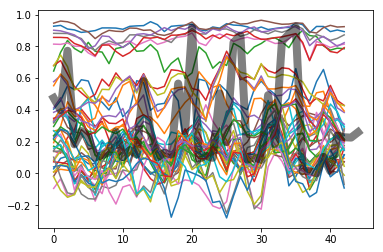

In [314]:
plot_3D_trace(all_mats=all_corrs_stack_l, l_chnl_num=75, u_chnl_num=85)

43


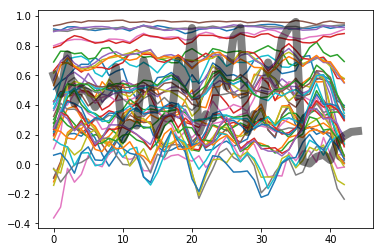

In [315]:
plot_3D_trace(all_mats=all_corrs_stack_h, l_chnl_num=75, u_chnl_num=85)

In [ ]:
plot_W_avg_split_high_low_freq(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data, filter_row_idx=range(39), f_thresh=60)

In [ ]:
plot_W_split_high_low_freq(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data, filter_row_idx=range(39), f_thresh=60)

In [135]:
# P41 words with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper_high_low_freq(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data",
                              low_f=True)

85
(81, 43, 1)


In [136]:
# P41 words with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper_high_low_freq(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data",
                              low_f=False)

85
(81, 43, 1)


In [137]:
# P35 words with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper_high_low_freq(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data",
                              low_f=True)

# P35 words with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper_high_low_freq(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data",
                              low_f=False)

85
(80, 43, 1)
85
(80, 43, 1)


In [139]:
# P41 words with P35_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper_high_low_freq(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data",
                              low_f=True)

# P41 words with P35_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper_high_low_freq(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data",
                              low_f=False)

85
(81, 43, 1)
85
(81, 43, 1)


In [242]:
# P41 words with P35_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack_l = plot_chnl_W_proj_corr_wrapper_high_low_freq(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data",
                              low_f=True)

# P41 words with P35_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack_h = plot_chnl_W_proj_corr_wrapper_high_low_freq(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data",
                              low_f=False)

85
(80, 43, 1)
85
(80, 43, 1)


43


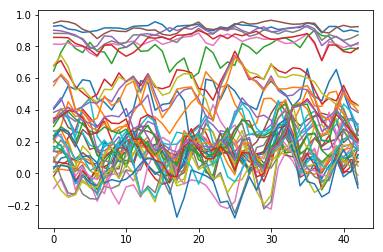

In [243]:
plot_3D_trace(all_mats=all_corrs_stack_l, l_chnl_num=75, u_chnl_num=85)

43


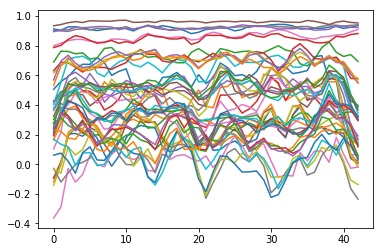

In [244]:
plot_3D_trace(all_mats=all_corrs_stack_h, l_chnl_num=75, u_chnl_num=85)

In [213]:
a = np.reshape(range(125),(5,5,5))
a.shape
a[:, :, 0]

array([[  0,   5,  10,  15,  20],
       [ 25,  30,  35,  40,  45],
       [ 50,  55,  60,  65,  70],
       [ 75,  80,  85,  90,  95],
       [100, 105, 110, 115, 120]])

In [221]:
a[3:, 3:, :]

(2, 2, 5)

5


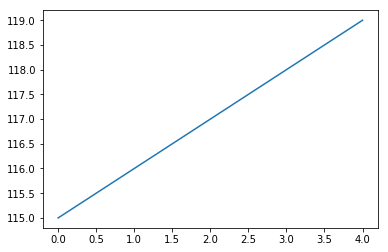

In [224]:
plot_3D_trace(all_mats=a[3:, 3:, :])

In [ ]:
all_corrs_stack[:]

In [108]:
W_all_data_src = P41_allcats_32ptrl_ncomp_high_data
W_plt = W_all_data_src['W_plt']
f_thresh = 70
f_Sxx = W_all_data_src['f'][filter_row_idx]

out_all_W_f, out_all_W_f_s, W_f_avg = get_W_low_high_freq(f_Sxx=f_Sxx, f_thresh=f_thresh, W_mat=W_plt, low_f=True)

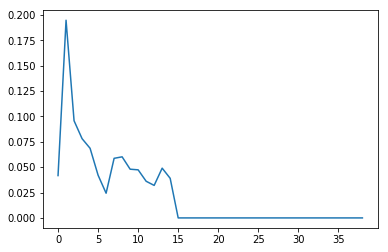

In [114]:
plt.plot(W_f_avg)

## Project on P41 words/ faces for W component 2/ 16 using P41_allcats_32ptrl_ncomp_high_data

In [42]:
# P41 words with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data")

# P41 words with P41_allcats_32ptrl_ncomp_high_data, W comp 16
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=16,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data")

# P41 faces with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_faces_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data")

# P41 faces with P41_allcats_32ptrl_ncomp_high_data, W comp 16
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_faces_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=16,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data")

## Project on P41 words/ faces for W component 2/ 16 using P35_allcats_32ptrl_ncomp_high_data

In [43]:
# P41 words with P35_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=4,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data")

# P41 words with P41_allcats_32ptrl_ncomp_high_data, W comp 16
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=11,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data")

# P41 faces with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_faces_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=4,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data")

# P41 faces with P41_allcats_32ptrl_ncomp_high_data, W comp 16
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P41_faces_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=11,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data")

## Project on P35 words/ faces for W component 2/ 16 using P41_allcats_32ptrl_ncomp_high_data

In [44]:
# P35 words with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data")

# P35 words with P41_allcats_32ptrl_ncomp_high_data, W comp 16
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=16,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data")

# P35 faces with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_faces_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data")

# P35 faces with P41_allcats_32ptrl_ncomp_high_data, W comp 16
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_faces_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=16,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data")

In [57]:
# P35 hammers with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_hammers_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=2,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data")

# P35 hammers with P41_allcats_32ptrl_ncomp_high_data, W comp 16
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_hammers_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=16,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P41_allcats_32ptrl_ncomp_high_data")

## Project on P35 words/ faces for W component 2/ 16 using P35_allcats_32ptrl_ncomp_high_data

In [45]:
# P35 words with P35_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=4,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data")

# P35 words with P41_allcats_32ptrl_ncomp_high_data, W comp 16
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_words_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=11,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data")

# P35 faces with P41_allcats_32ptrl_ncomp_high_data, W comp 2
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_faces_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=4,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data")

# P35 faces with P41_allcats_32ptrl_ncomp_high_data, W comp 16
get_all_dat, get_all_W_comp_dat, all_corrs_stack = plot_chnl_W_proj_corr_wrapper(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                              speccat_src=P35_faces_data,
                              chnl_num=20,
                              filter_row_idx=range(39),
                              mat_ord='fro',
                              f_thresh=60, 
                              zerioze_post=None,
                              num_plot_cols=4,
                              num_channels=85,
                              W_comp_num=11,
                              corr_method='spearman',
                              produce_plots=False,
                              save_plots=True,
                              plot_name="P35_allcats_32ptrl_ncomp_high_data")

## Plot correlations for a given channel across all $W$'s

In [35]:
def plot_chnl_sliceW_proj_corr_wrapper(W_all_data_src,
                                       speccat_src,
                                       chnl_num,
                                       comp_chnl_nums,
                                       filter_row_idx,
                                       mat_ord,
                                       f_thresh, 
                                       zerioze_post,
                                       num_plot_cols,
                                       num_channels,
                                       W_comp_num,
                                       corr_method,
                                       produce_plots):
    
    chnl_idx = chnl_num - 1
    comp_chnl_idx = [chnl_num - 1 for chnl_num in comp_chnl_nums]
    
    num_plot_cols = int(num_plot_cols)
    #W_comp_idx = W_comp_num - 1
    
    get_all_dat = [get_wrapper_stft_W_proj_data(W_all_data_src=W_all_data_src,
                                               speccat_src=speccat_src,
                                               chnl_num=chnl_idx + 1, # Change channel index to channel number
                                               filter_row_idx=filter_row_idx,
                                               mat_ord=mat_ord,
                                               f_thresh=f_thresh, 
                                               zerioze_post=zerioze_post) for chnl_idx in range(num_channels)]
    
    W_plt = W_all_data_src['W_plt']
    
    # Get the Frobenius normalized W matrix
    # This will be used for plotting and also applying the scaling
    W_plt = W_all_data_src['W_plt']
    
    # Get the number of W components we will project onto
    n_components = W_plt.shape[1]
    #n_components = 1
    
    # This is used to plot the x components on W_plt
    x_ticks_l = W_all_data_src['f'][filter_row_idx]
    
    for comp_idx in range(n_components):
        
        # Set up the subplots
        fig, axs = plt.subplots(1,2, figsize=(15, 6), facecolor='w', edgecolor='k', squeeze=False)
        fig.subplots_adjust(hspace = 0.5, wspace=0.2)        
        axs = axs.flatten()
        
        # Get the W matrix
        W_specnorm = W_all_data_src['W_specnorm']
        
        W_comp_scl2 = get_W_comp_zeroized(f_Sxx=W_all_data_src['f'][filter_row_idx], 
                                          f_thresh=f_thresh, 
                                          zerioze_post=zerioze_post, 
                                          W_mat=W_specnorm, 
                                          comp_idx=comp_idx)

        
        get_all_W_comp_dat = np.dstack([chnl_dat[:, :, comp_idx] for chnl_dat in get_all_dat])
        n_time_comps = get_all_W_comp_dat.shape[1]
        all_corrs = [pd.DataFrame(get_all_W_comp_dat[:, i, :]).corr(method=corr_method) for i in range(n_time_comps)]
        all_corrs_stack = np.dstack(all_corrs)
        
        fig.suptitle(f"W Component: {comp_idx + 1}", fontsize=14)
        
        t_stft = speccat_src['t_stft']*1000
                
        # W Component
        #axs[0].plot(W_plt[:, comp_idx])
        axs[0].plot(W_comp_scl2)
        axs[0].set_ylim(0, W_comp_scl2.max())
        axs[0].set_title(f"W{comp_idx + 1}, P{W_all_data_src['patient_num']}, Session {W_all_data_src['session_idx']}, {W_all_data_src['core_cat']}", fontsize=14)
        axs[0].set_xticks(range(0, len(W_comp_scl2)))
        axs[0].set_xticklabels(np.around(x_ticks_l), rotation='vertical')
        axs[0].set_xlabel('Frequency')
                
        W_trunc = all_corrs_stack[comp_chnl_idx, chnl_idx, :]
        W_trunc_mean = np.mean(a=W_trunc, axis=0)
        axs[1].plot(W_trunc.T[:,:])
        axs[1].set_xticks(range(len(t_stft)))
        axs[1].set_xticklabels(np.around(t_stft*1000, 0), rotation='vertical')
        axs[1].set_title(f"Corr: {corr_method}, Channel {chnl_num} vs. other chnls, Category {speccat_src['core_cat']}", fontsize=14)
        axs[1].legend(labels=comp_chnl_nums, loc=0)
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel(f"W-Scaled STFT")
        plt.plot(W_trunc_mean, marker='', color='black', linewidth=8, alpha=1.5)

## P41 - Session 1, $W$ All Categories - Correlation for each $W$ component by projecting on P41 (only face trials)

### Correlation of Channel 20 (face trials) with word sensitive channels

In [ ]:
plot_chnl_sliceW_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                                   speccat_src=P41_faces_data,
                                   chnl_num=20,
                                   comp_chnl_nums=[3, 8, 9, 12, 21, 22],
                                   filter_row_idx=range(39),
                                   mat_ord='fro',
                                   f_thresh=60,
                                   zerioze_post=None,
                                   num_plot_cols=4,
                                   num_channels=96,
                                   W_comp_num=6,
                                   corr_method='spearman',
                                   produce_plots=False)

## P41 - Session 1, $W$ All Categories - Correlation for each $W$ component by projecting on P41 (only face trials)

### Correlation of Channel 20 (face trials) with first 30 channels

In [ ]:
plot_chnl_sliceW_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                                   speccat_src=P41_faces_data,
                                   chnl_num=20,
                                   comp_chnl_nums=list(range(1,20)) + list(range(21,30)),
                                   filter_row_idx=range(39),
                                   mat_ord='fro',
                                   f_thresh=60,
                                   zerioze_post=None,
                                   num_plot_cols=4,
                                   num_channels=96,
                                   W_comp_num=6,
                                   corr_method='spearman',
                                   produce_plots=False)

## P41 - Session 1, $W$ All Categories - Correlation for each $W$ component by projecting on P41 (only face trials)

### Correlation of Channel 12 (word sensitive trials) with first face sensitive channels

In [ ]:
plot_chnl_sliceW_proj_corr_wrapper(W_all_data_src=P41_allcats_32ptrl_ncomp_high_data,
                                   speccat_src=P41_faces_data,
                                   chnl_num=12,
                                   comp_chnl_nums=[10, 11, 13, 20, 24],
                                   filter_row_idx=range(39),
                                   mat_ord='fro',
                                   f_thresh=60,
                                   zerioze_post=None,
                                   num_plot_cols=4,
                                   num_channels=96,
                                   W_comp_num=6,
                                   corr_method='spearman',
                                   produce_plots=False)

## P35 - Session 1, $W$ All Categories - Correlation for each $W$ component by projecting on P41 (only face trials)

### Correlation of Channel 20 (face trials) with word sensitive channels

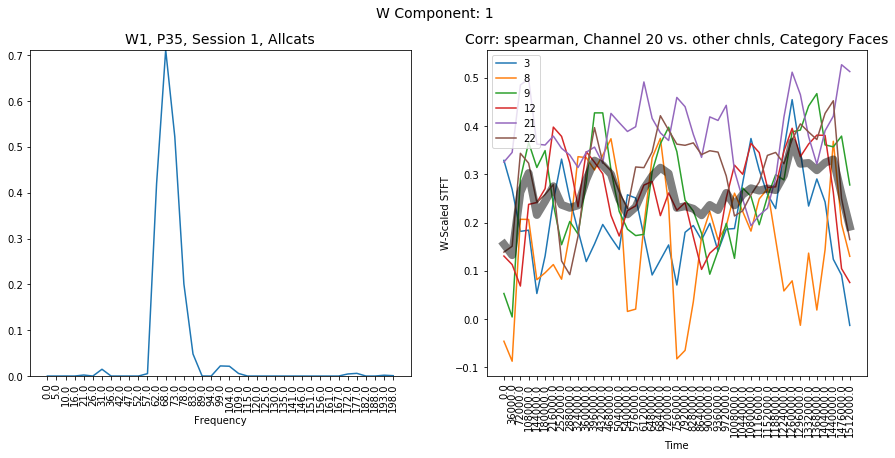

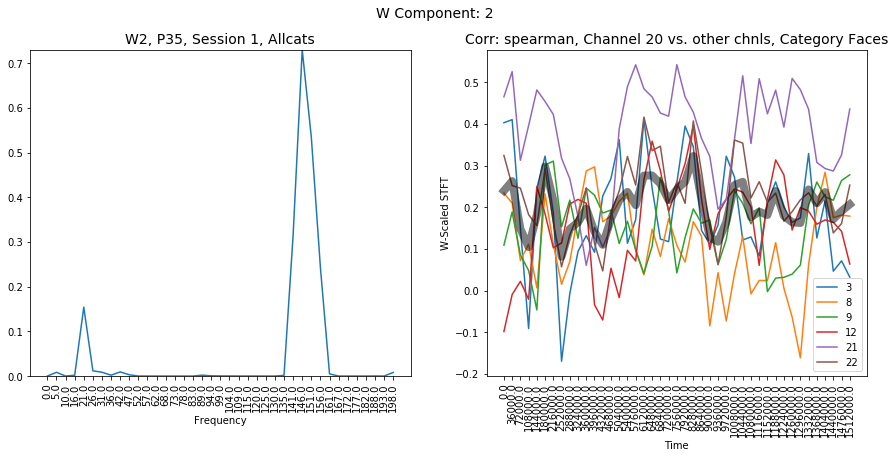

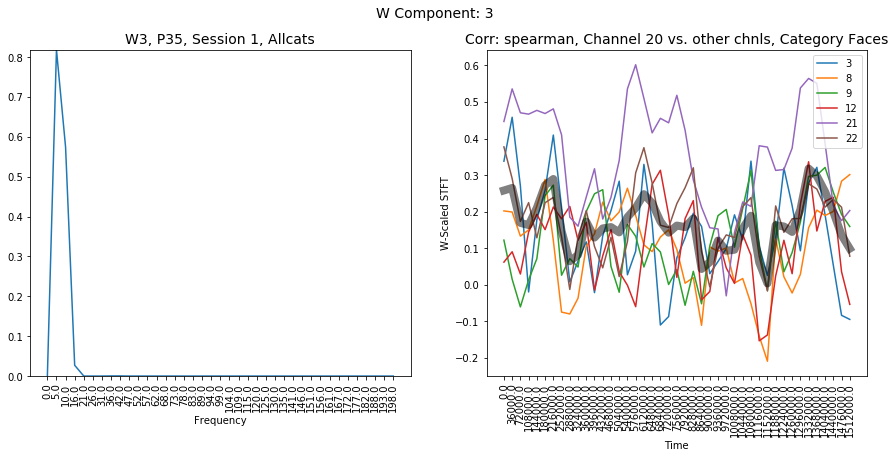

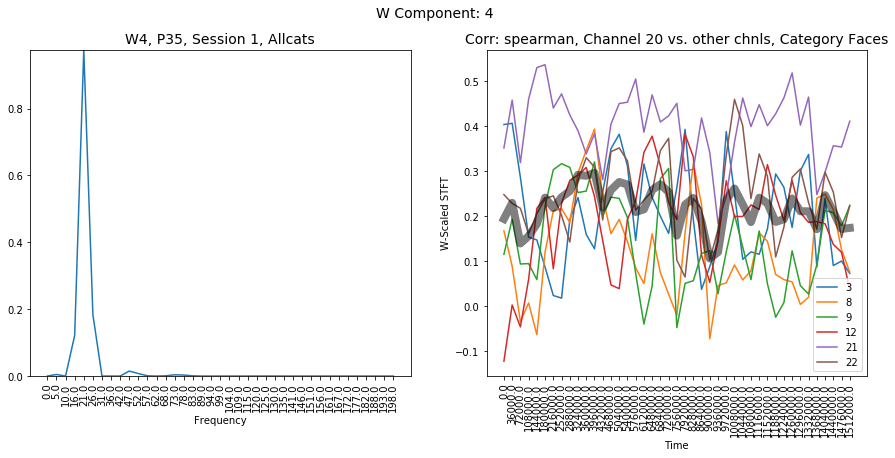

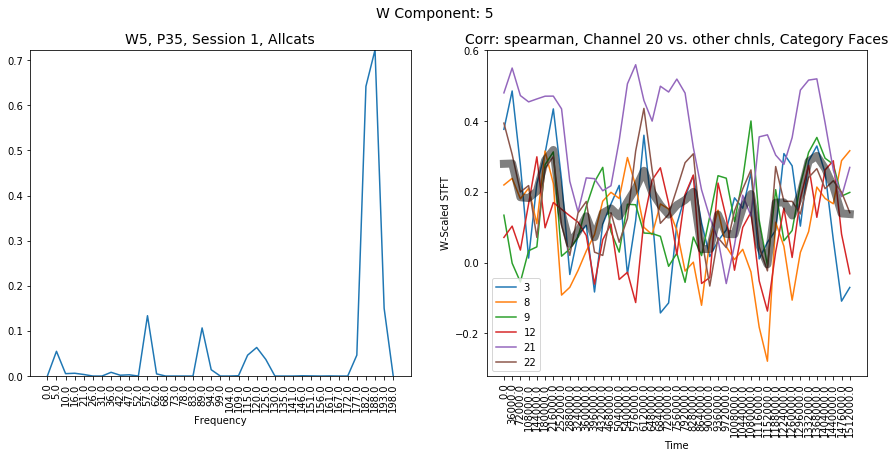

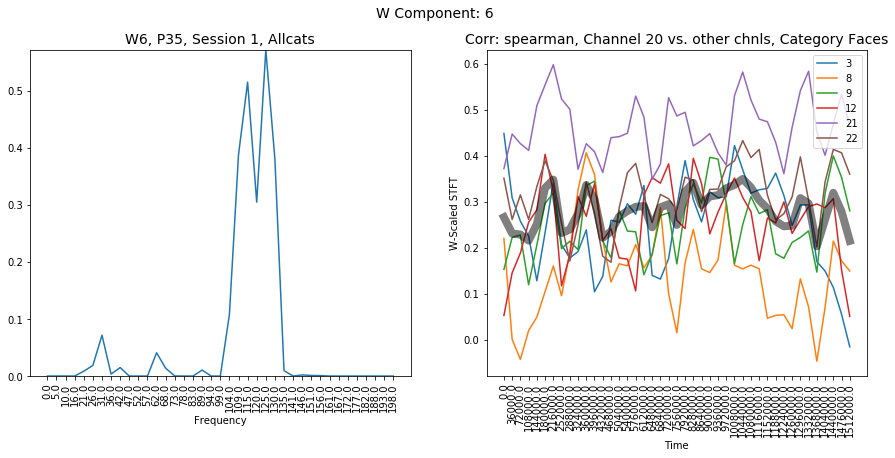

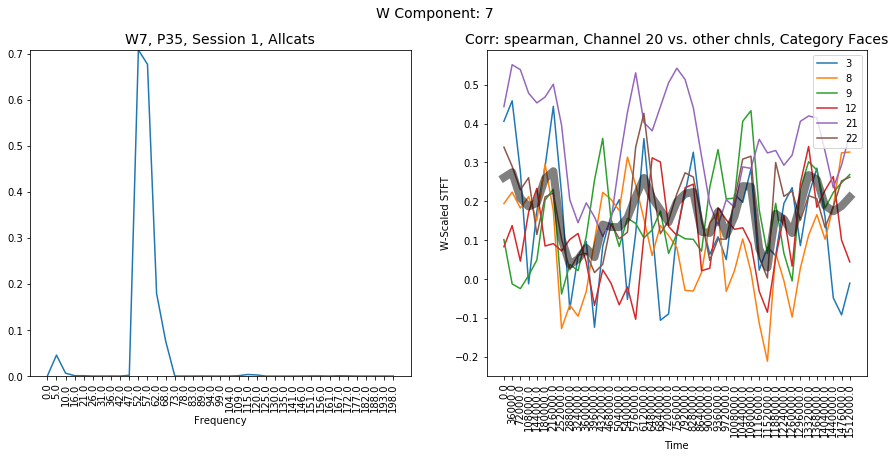

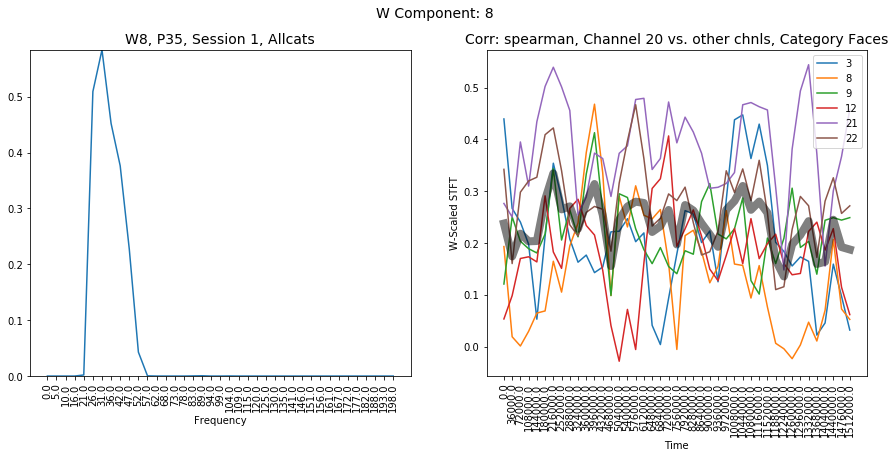

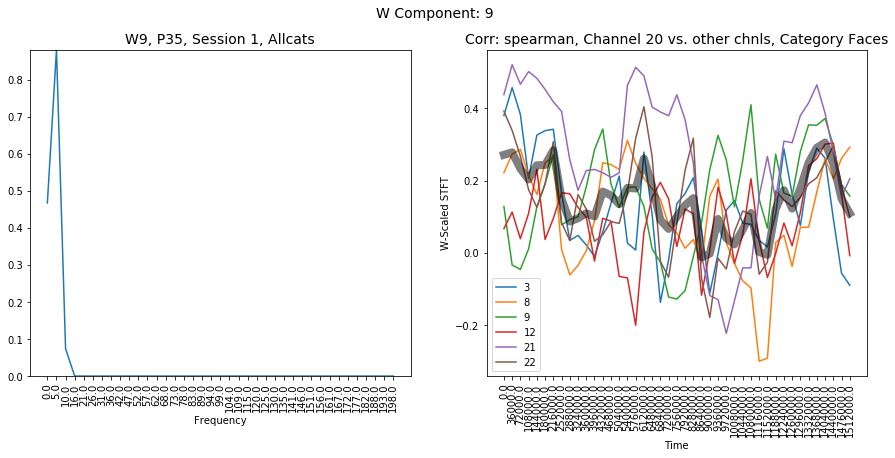

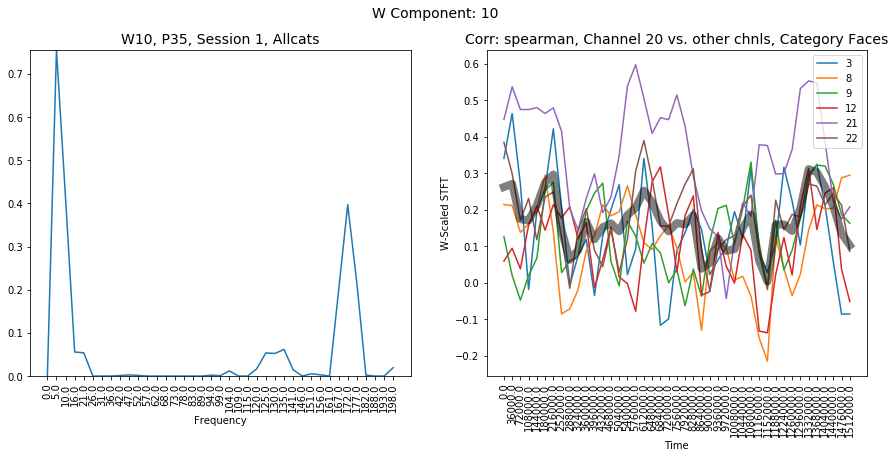

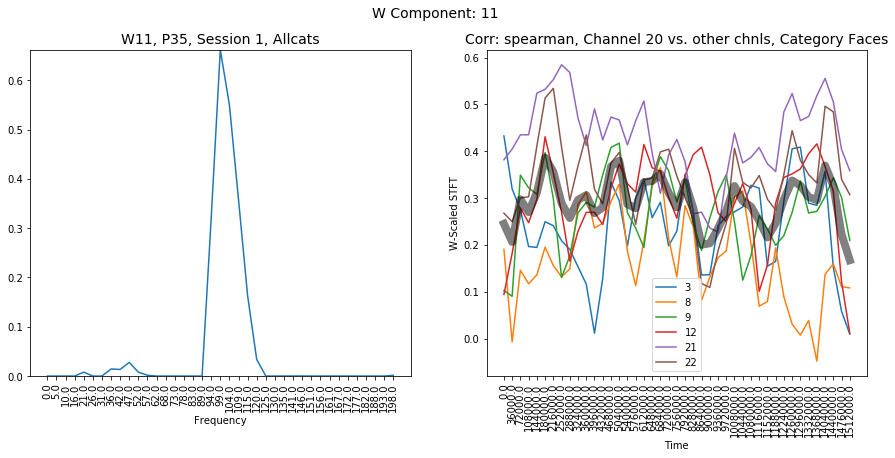

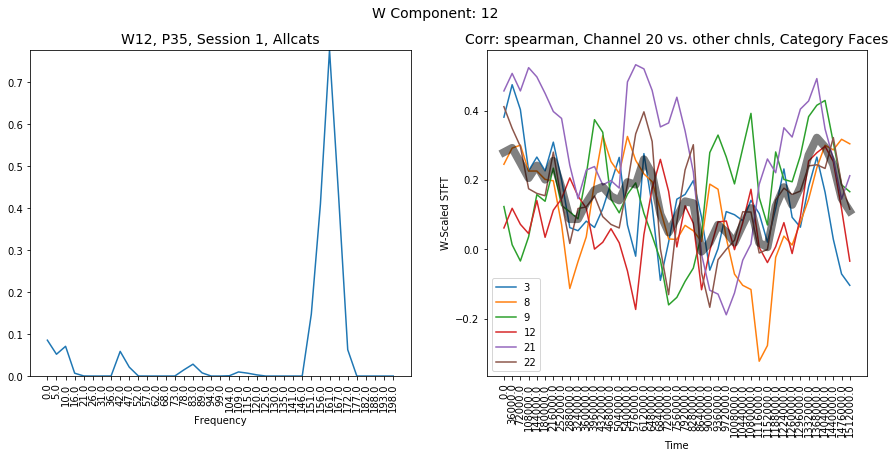

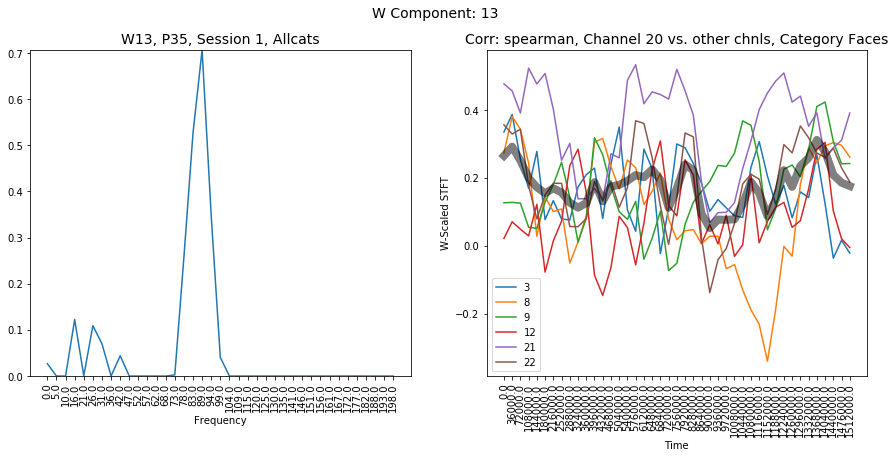

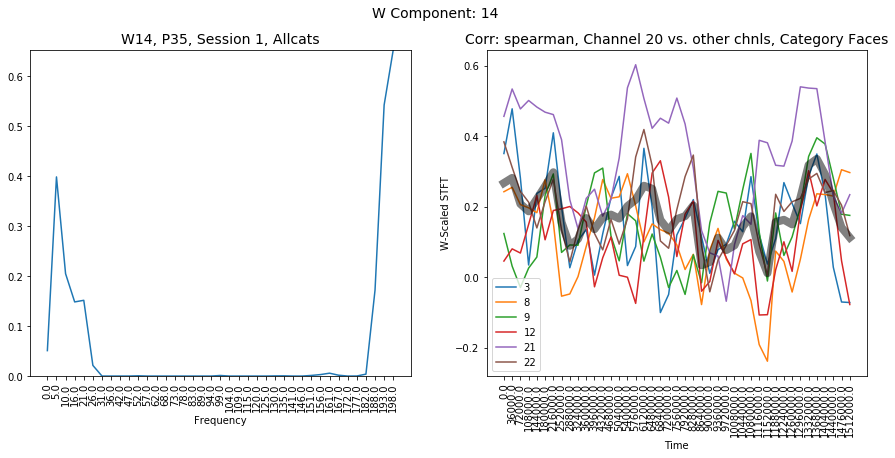

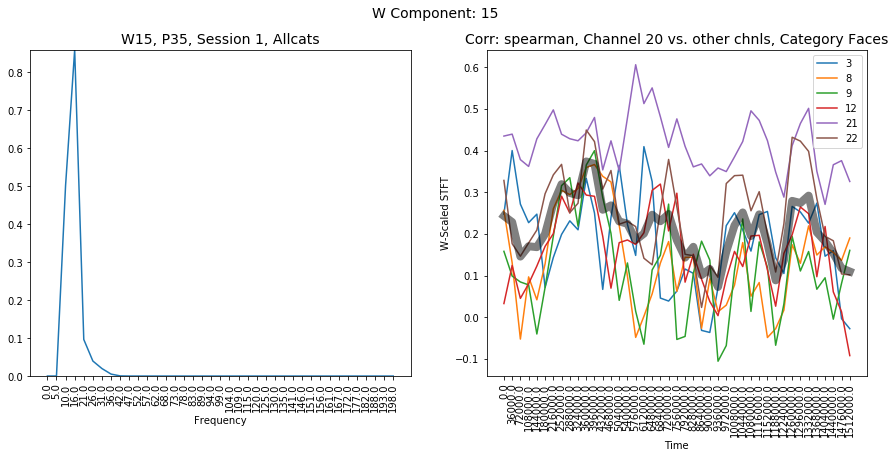

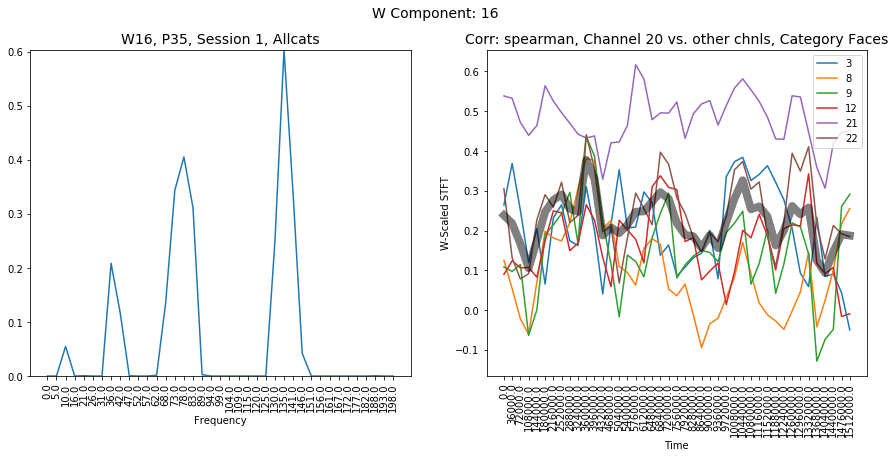

In [36]:
plot_chnl_sliceW_proj_corr_wrapper(W_all_data_src=P35_allcats_32ptrl_ncomp_high_data,
                                   speccat_src=P41_faces_data,
                                   chnl_num=20,
                                   comp_chnl_nums=[3, 8, 9, 12, 21, 22],
                                   filter_row_idx=range(39),
                                   mat_ord='fro',
                                   f_thresh=60,
                                   zerioze_post=None,
                                   num_plot_cols=4,
                                   num_channels=96,
                                   W_comp_num=6,
                                   corr_method='spearman',
                                   produce_plots=False)

In [227]:
N = 12
T = 10

all_mats = np.dstack([(np.random.uniform(-1,1,size=(N,N)) + 
                       np.random.uniform(-1,1,size=(N,N)).T)/2 for t in range(T)])

# This is (3, 3, 10)
all_mats.shape

(12, 12, 10)

In [228]:
fin_plt_mat = np.hstack([get_lower_tri_vec(inp_mat=all_mats[:, :, t], k=-1) for t in range(T)])
fin_plt_mat.shape

(66, 10)

10


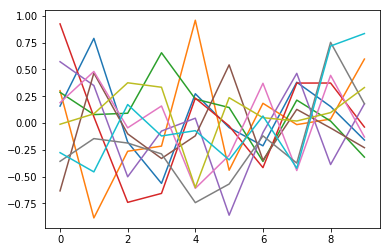

In [231]:
plot_3D_trace(all_mats=all_mats[5:10, 5:10, :])

In [226]:
all_mats[3:, 3:, :].shape

(3, 3, 10)